<div dir="rtl" style="font-family: 'IRANSans', 'Tahoma', sans-serif;">

## مرور کلی

این مستندات پیاده‌سازی سفارشی طبقه‌بندی اشیاء نجومی با استفاده از درختان تصمیم را پوشش می‌دهد که به طور خاص برای مجموعه داده‌های بررسی دیجیتال آسمان اسلون (SDSS) طراحی شده است. این پیاده‌سازی بر موارد زیر تأکید دارد:

1. پیش‌پردازش داده‌های مختص نجوم
2. مهندسی ویژگی برای خصوصیات اخترفیزیکی
3. پیاده‌سازی سفارشی درخت تصمیم
4. تکنیک‌های ارزیابی مدل
5. تحلیل اهمیت ویژگی‌ها

## فهرست مطالب

1. [بارگذاری و بررسی داده‌ها](#بارگذاری-و-بررسی-داده‌ها)
2. [مهندسی ویژگی‌ها](#مهندسی-ویژگی‌ها)
3. [پیاده‌سازی‌های پیش‌پردازش سفارشی](#پیاده‌سازی‌های-پیش‌پردازش-سفارشی)
   - [CustomPCA](#custompca)
   - [RobustScaler](#robustscaler)
   - [SelectKBest](#selectkbest)
4. [توابع پیش‌پردازش داده‌ها](#توابع-پیش‌پردازش-داده‌ها)
5. [پیاده‌سازی درخت تصمیم](#پیاده‌سازی-درخت-تصمیم)
6. [ارزیابی مدل](#ارزیابی-مدل)
---

 نویسنده: [محمدمهدی شریف‌بیگی][(sharifbeigymohammad@gmail.com)](https://github.com/MohammadMahdi-Sharifbeigy)

 تاریخ: [25/3/2025]
</div>

In [87]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import itertools
from graphviz import Digraph


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV , KFold, learning_curve
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, RobustScaler, StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix , precision_score, recall_score, f1_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from scipy import stats
from xgboost import XGBClassifier, plot_importance
import warnings
warnings.filterwarnings('ignore')


<div dir="rtl" style="font-family: 'IRANSans', 'Tahoma', sans-serif;">

## بارگذاری و بررسی داده‌ها

### `load_and_explore_data(filepath, verbose=True)`

داده‌های نجومی را بارگذاری کرده و بررسی اولیه را انجام می‌دهد.

**پارامترها:**
- `filepath`: مسیر فایل CSV مجموعه داده SDSS
- `verbose`: آیا اطلاعات بررسی چاپ شود

**خروجی:**
- دیتافریم با داده‌های بارگذاری شده

**توضیحات:**
مجموعه داده SDSS معمولاً شامل اندازه‌گیری‌های نجومی زیر است:
- `objid`، `specobjid`: شناسه‌های اشیاء در کاتالوگ SDSS
- `ra`، `dec`: میل و بعد (مختصات آسمانی)
- `u`، `g`، `r`، `i`، `z`: قدرهای ظاهری در پنج باند فوتومتری
- `redshift`: انتقال به سرخ شیء، مرتبط با فاصله/سرعت دور شدن
- `class`: طبقه‌بندی شیء (کهکشان، کوازار/QSO، یا ستاره)

---
</div>

In [88]:
def load_and_explore_data(filepath, verbose=True):
    data = pd.read_csv(filepath)
    
    if verbose:
        print("Dataset loaded successfully with shape:", data.shape)
        print("\nFirst few rows:")
        print(data.head())
        
        missing_values = data.isnull().sum()
        if missing_values.sum() > 0:
            print("\nMissing values per column:")
            print(missing_values[missing_values > 0])
        else:
            print("\nNo missing values found in the dataset")
        
        print("\nDataset Information:")
        print(data.info())
        
        print("\nClass Distribution:")
        class_dist = data['class'].value_counts()
        print(class_dist)
        
        plt.figure(figsize=(10, 6))
        sns.countplot(x='class', data=data)
        plt.title('Distribution of Astronomical Object Classes')
        plt.xlabel('Object Class')
        plt.ylabel('Count')
        plt.grid(axis='y', alpha=0.3)
        plt.show()
    
    return data


------------------------------------------------------------------------------

 PART 2: FEATURE ENGINEERING FOR ASTRONOMICAL DATA

------------------------------------------------------------------------------

<div dir="rtl" style="font-family: 'IRANSans', 'Tahoma', sans-serif;">

## Feature Engineering

### `engineer_astronomical_features(df)`

ویژگی‌های مبتنی بر فیزیک با استفاده از دانش نجومی ایجاد می‌کند.

**پارامترها:**
- `df`: دیتافریم با اندازه‌گیری‌های اصلی نجومی

**خروجی:**
- دیتافریم بهبود یافته با ویژگی‌های مهندسی شده

**ویژگی‌های ایجاد شده:**
1. **شاخص‌های رنگی**: تفاوت بین قدرهای ظاهری در باندهای مجاور
   - `u_g = u - g` (فرابنفش منهای سبز)
   - `g_r = g - r` (سبز منهای قرمز)
   - `r_i = r - i` (قرمز منهای مادون قرمز نزدیک)
   - `i_z = i - z` (مادون قرمز نزدیک منهای مادون قرمز)

2. **ویژگی‌های مشتق شده از انتقال به سرخ**:
   - `log_redshift = log(1 + redshift)`
   - `distance_modulus = 5 * log10(redshift * c / H0) + 25`

---
</div>

In [89]:

def engineer_astronomical_features(df):
    df_enhanced = df.copy()
    
    # 1. Create color indices if the magnitude bands exist
    if all(col in df.columns for col in ['u', 'g', 'r', 'i', 'z']):
        # u-g color (ultraviolet minus green)
        df_enhanced['u_g'] = df['u'] - df['g']  
        
        # g-r color (green minus red)
        df_enhanced['g_r'] = df['g'] - df['r']
        
        # r-i color (red minus near-infrared)
        df_enhanced['r_i'] = df['r'] - df['i']
        
        # i-z color (near-infrared minus infrared)
        df_enhanced['i_z'] = df['i'] - df['z']
    
    # 2. Create redshift-derived features
    if 'redshift' in df.columns:
        df_enhanced['log_redshift'] = np.log1p(df['redshift'])
        
        # Distance modulus approximation (used in astronomy)
        H0 = 70  # Hubble constant in km/s/Mpc
        c = 299792.458  # Speed of light in km/s
        
        df_enhanced['distance_modulus'] = 5 * np.log10(
            np.maximum(1e-10, df['redshift'] * c / H0)
        ) + 25
    
    return df_enhanced


------------------------------------------------------------------------------

 PART 3: CUSTOM PREPROCESSING IMPLEMENTATIONS

------------------------------------------------------------------------------

<div style="font-family: 'IRANSans', 'Tahoma', sans-serif;">

## Custom Preprocessing Implementations

### CustomPCA

پیاده‌سازی سفارشی تحلیل مؤلفه‌های اصلی برای کاهش ابعاد.

#### `__init__(n_components=None)`
PCA را مقداردهی اولیه می‌کند.

**پارامترها:**
- `n_components`: تعداد مؤلفه‌هایی که باید حفظ شوند

#### `fit(X)`
مدل PCA را با X تطبیق می‌دهد.

**پارامترها:**
- `X`: داده‌های آموزشی

#### `transform(X)`
داده‌ها را روی مؤلفه‌های اصلی تصویر می‌کند.

**پارامترها:**
- `X`: داده‌هایی که باید تبدیل شوند

#### `inverse_transform(X)`
داده‌ها را به فضای اصلی برمی‌گرداند.

**پارامترها:**
- `X`: داده‌های با ابعاد کاهش یافته

#### `fit_transform(X)`
تطبیق و تبدیل را در یک مرحله ترکیب می‌کند.

#### فرمول‌بندی ریاضی پیشرفته

با فرض یک مجموعه داده نجومی با $n$ مشاهده و $d$ ویژگی (مانند قدرهای ظاهری، رنگ‌ها، شاخص‌های طیفی)، نمایش داده شده به صورت ماتریس $\mathbf{X} \in \mathbb{R}^{n \times d}$، PCA به دنبال یافتن نمایشی با ابعاد کمتر است که بیشترین واریانس را حفظ کند.

##### مرکززدایی ماتریس

ماتریس داده مرکززدایی شده $\mathbf{X}_c$ با کم کردن میانگین هر ویژگی محاسبه می‌شود:

$\mathbf{X}_c = \mathbf{X} - \mathbf{1}\boldsymbol{\mu}^T$

که در آن $\boldsymbol{\mu} \in \mathbb{R}^d$ بردار میانگین با عناصر $\mu_j = \frac{1}{n}\sum_{i=1}^{n} x_{ij}$ است و $\mathbf{1} \in \mathbb{R}^n$ یک بردار از یک‌ها است.

##### ماتریس کوواریانس

ماتریس کوواریانس نمونه $\mathbf{\Sigma}$ به صورت زیر تعریف می‌شود:

$\mathbf{\Sigma} = \frac{1}{n-1}\mathbf{X}_c^T\mathbf{X}_c \in \mathbb{R}^{d \times d}$

هر عنصر $\sigma_{jk}$ نشان‌دهنده کوواریانس بین ویژگی‌های $j$ و $k$ است:

$\sigma_{jk} = \frac{1}{n-1}\sum_{i=1}^{n}(x_{ij} - \mu_j)(x_{ik} - \mu_k)$

برای داده‌های نجومی، این روابط بین باندهای طول موج مختلف یا خصوصیات مشتق شده را نشان می‌دهد.

##### روش تجزیه ویژه مقدار

ماتریس کوواریانس به مقادیر ویژه و بردارهای ویژه خود تجزیه می‌شود:

$\mathbf{\Sigma} = \mathbf{V}\mathbf{\Lambda}\mathbf{V}^T$

که در آن:
- $\mathbf{V} \in \mathbb{R}^{d \times d}$ ماتریس متعامد بردارهای ویژه $\mathbf{v}_1, \mathbf{v}_2, ..., \mathbf{v}_d$ است
- $\mathbf{\Lambda} = \text{diag}(\lambda_1, \lambda_2, ..., \lambda_d)$ ماتریس قطری مقادیر ویژه است
- مقادیر ویژه به صورت نزولی مرتب شده‌اند: $\lambda_1 \geq \lambda_2 \geq ... \geq \lambda_d \geq 0$

هر بردار ویژه $\mathbf{v}_j$ و مقدار ویژه متناظر آن $\lambda_j$ در رابطه زیر صدق می‌کنند:

$\mathbf{\Sigma}\mathbf{v}_j = \lambda_j\mathbf{v}_j$

##### روش تجزیه مقدار تکین (SVD)

روش جایگزین و از نظر عددی پایدارتر، استفاده از SVD است که مستقیماً ماتریس داده مرکززدایی شده را تجزیه می‌کند:

$\mathbf{X}_c = \mathbf{U}\mathbf{S}\mathbf{V}^T$

که در آن:
- $\mathbf{U} \in \mathbb{R}^{n \times n}$ یک ماتریس متعامد حاوی بردارهای تکین چپ است
- $\mathbf{S} \in \mathbb{R}^{n \times d}$ یک ماتریس قطری مستطیلی با مقادیر تکین $s_1 \geq s_2 \geq ... \geq s_{\\min(n,d)} \geq 0$ است
- $\mathbf{V} \in \mathbb{R}^{d \times d}$ یک ماتریس متعامد حاوی بردارهای تکین راست است

رابطه بین SVD و تجزیه ویژه مقدار:
- بردارهای تکین راست در $\mathbf{V}$ با بردارهای ویژه $\mathbf{\Sigma}$ یکسان هستند
- مقادیر تکین و مقادیر ویژه با هم مرتبط هستند: $s_i^2 = (n-1) \lambda_i$

##### مؤلفه‌های اصلی و کاهش ابعاد

مؤلفه‌های اصلی با تصویر داده‌های مرکززدایی شده روی بردارهای ویژه به دست می‌آیند:

$\mathbf{T} = \mathbf{X}_c\mathbf{V} \in \mathbb{R}^{n \times d}$

برای کاهش ابعاد به $k < d$ مؤلفه، فقط از $k$ بردار ویژه اول استفاده می‌کنیم:

$\mathbf{T}_k = \mathbf{X}_c\mathbf{V}_k \in \mathbb{R}^{n \times k}$

که در آن $\mathbf{V}_k \in \mathbb{R}^{d \times k}$ شامل $k$ بردار ویژه اول است.

##### واریانس توضیح داده شده

نسبت واریانس توضیح داده شده توسط $j$-امین مؤلفه اصلی برابر است با:

$\text{نسبت واریانس توضیح داده شده}_j = \frac{\lambda_j}{\sum_{i=1}^{d}\lambda_i}$

واریانس تجمعی توضیح داده شده برای $k$ مؤلفه برابر است با:

$\text{واریانس تجمعی توضیح داده شده}_k = \frac{\sum_{j=1}^{k}\lambda_j}{\sum_{i=1}^{d}\lambda_i}$

برای داده‌های نجومی، این به تعیین تعداد مؤلفه‌های مورد نیاز برای حفظ اطلاعات اساسی کمک می‌کند.

##### بازسازی داده‌ها

داده‌های اصلی می‌توانند به طور تقریبی از نمایش کاهش یافته بازسازی شوند:

$\hat{\mathbf{X}} = \mathbf{T}_k\mathbf{V}_k^T + \mathbf{1}\boldsymbol{\mu}^T$

خطای بازسازی با میانگین مربعات خطا کمی می‌شود:

$\text{MSE} = \frac{1}{nd}\\|\mathbf{X} - \hat{\mathbf{X}}\\|_F^2 = \frac{1}{nd}\sum_{j=k+1}^{d}\lambda_j$

که در آن $\\|\cdot\\|_F$ نُرم فروبنیوس است.

##### مثال ماتریسی

یک مجموعه داده نجومی ساده با 4 شیء و 3 ویژگی (قدرهای ظاهری در باندهای مختلف) را در نظر بگیرید:

$\mathbf{X} = \begin{bmatrix} 
2.1 & 1.5 & 3.1 \\
3.5 & 2.7 & 4.2 \\
1.8 & 1.3 & 2.8 \\
2.6 & 2.0 & 3.5
\end{bmatrix}$

**گام 1**: محاسبه بردار میانگین

$\boldsymbol{\mu} = \begin{bmatrix} 2.5 & 1.875 & 3.4 \end{bmatrix}$

**گام 2**: مرکززدایی داده‌ها

$\mathbf{X}_c = \begin{bmatrix} 
-0.4 & -0.375 & -0.3 \\
1.0 & 0.825 & 0.8 \\
-0.7 & -0.575 & -0.6 \\
0.1 & 0.125 & 0.1
\end{bmatrix}$

**گام 3**: محاسبه ماتریس کوواریانس

$\mathbf{\Sigma} = \frac{1}{3}\mathbf{X}_c^T\mathbf{X}_c = \begin{bmatrix} 
0.517 & 0.433 & 0.467 \\
0.433 & 0.365 & 0.392 \\
0.467 & 0.392 & 0.423
\end{bmatrix}$

**گام 4**: یافتن مقادیر ویژه و بردارهای ویژه

$\lambda_1 = 1.295, \quad \mathbf{v}_1 = \begin{bmatrix} 0.58 \\ 0.49 \\ 0.53 \end{bmatrix}$

$\lambda_2 = 0.010, \quad \mathbf{v}_2 = \begin{bmatrix} -0.54 \\ 0.83 \\ -0.15 \end{bmatrix}$

$\lambda_3 = 0.001, \quad \mathbf{v}_3 = \begin{bmatrix} 0.61 \\ 0.28 \\ -0.74 \end{bmatrix}$

**گام 5**: تصویر داده‌ها روی مؤلفه‌های اصلی (2 مؤلفه اول)

$\mathbf{T}_2 = \mathbf{X}_c \begin{bmatrix} 
0.58 & -0.54 \\
0.49 & 0.83 \\
0.53 & -0.15
\end{bmatrix} = \begin{bmatrix} 
-0.62 & 0.035 \\
1.52 & 0.122 \\
-1.08 & -0.026 \\
0.19 & -0.131
\end{bmatrix}$

مؤلفه اصلی اول 99.1% از واریانس را توضیح می‌دهد، که نشان می‌دهد سه ویژگی اصلی به شدت با هم همبستگی دارند.
</div>

In [90]:

class CustomPCA:
    
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.components_ = None
        self.explained_variance_ = None
        self.explained_variance_ratio_ = None
        self.mean_ = None
        self.n_samples_ = None
        self.n_features_ = None
    
    def fit(self, X):
        self.n_samples_, self.n_features_ = X.shape
        
        self.mean_ = np.mean(X, axis=0)
        X_centered = X - self.mean_
        
        # Using the formula Cov(X) = (X^T X) / (n-1)
        cov_matrix = np.dot(X_centered.T, X_centered) / (self.n_samples_ - 1)
        
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        
        idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]
        
        if self.n_components is None:
            self.n_components = min(self.n_samples_, self.n_features_)
        elif isinstance(self.n_components, float):
            total_variance = np.sum(eigenvalues)
            cumulative_variance_ratio = np.cumsum(eigenvalues) / total_variance
            self.n_components = np.searchsorted(cumulative_variance_ratio, 
                                               self.n_components) + 1
        
        self.n_components = min(self.n_components, min(self.n_samples_, self.n_features_))
        
        self.components_ = eigenvectors[:, :self.n_components].T
        self.explained_variance_ = eigenvalues[:self.n_components]
        self.explained_variance_ratio_ = (self.explained_variance_ / 
                                         np.sum(eigenvalues))
        
        return self
    
    def transform(self, X):
        if self.components_ is None:
            raise ValueError("PCA model has not been fitted yet.")
        
        X_centered = X - self.mean_
        
        X_transformed = np.dot(X_centered, self.components_.T)
        
        return X_transformed
    
    def inverse_transform(self, X):
        if self.components_ is None:
            raise ValueError("PCA model has not been fitted yet.")
        
        X_original = np.dot(X, self.components_)
        
        X_original = X_original + self.mean_
        
        return X_original

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

<div dir="rtl" style="font-family: 'IRANSans', 'Tahoma', sans-serif;">

# RobustScaler: Scaling Features with Resilience to Outliers

## مرور کلی

`RobustScaler` یک تکنیک مقیاس‌دهی ویژگی‌ها است که برای مدیریت مجموعه داده‌هایی با داده‌های پرت قابل توجه طراحی شده است، که آن را به‌ویژه برای تحلیل داده‌های نجومی و علمی ارزشمند می‌سازد.

## ویژگی‌های کلیدی

- **مقاوم در برابر داده‌های پرت**: از میانه و دامنه میان‌چارکی (IQR) به جای میانگین و انحراف معیار استفاده می‌کند
- **مقیاس‌دهی انعطاف‌پذیر**: می‌تواند داده‌ها را به طور مستقل مرکززدایی و مقیاس‌دهی کند
- **محدوده چندک قابل تنظیم**: اجازه مشخص کردن محدوده‌های چندک سفارشی را می‌دهد

## پارامترها

### `with_centering` : bool، پیش‌فرض=True
- اگر `True` باشد، داده‌ها را با کم کردن میانه مرکززدایی می‌کند
- تأثیر مقادیر افراطی بر مقیاس‌دهی را کاهش می‌دهد

### `with_scaling` : bool، پیش‌فرض=True
- اگر `True` باشد، داده‌ها را با استفاده از دامنه میان‌چارکی مقیاس‌دهی می‌کند
- معیار مقاوم‌تری از پراکندگی داده‌ها ارائه می‌دهد

### `quantile_range` : tuple، پیش‌فرض=(25.0, 75.0)
- محدوده‌ای را برای محاسبه مقیاس تعریف می‌کند
- پیش‌فرض از کل دامنه میان‌چارکی (IQR) استفاده می‌کند
- فرمت: (چندک_پایین، چندک_بالا)

## ویژگی‌ها

### `center_` : ndarray
- مقادیر میانه برای هر ویژگی در مجموعه آموزش
- شکل: (n_features,)

### `scale_` : ndarray
- دامنه میان‌چارکی برای هر ویژگی
- شکل: (n_features,)

## فرمول تبدیل
X_scaled = (X - median) / (q_max - q_min)
که در آن:
- `X` ماتریس ورودی ویژگی‌ها است
- `median` میانه ویژگی به ویژگی است
- `q_max`، `q_min` مقادیر چندک مشخص شده هستند

## مثال

</div>

```python
import numpy as np
from custom_astro_ml import RobustScaler

X = np.array([
    [1., -2., 2.],     
    [2., 0., 0.],     
    [0., 1., -1.],    
    [1., 1., 1.],  
    [6., 10., 10.]     
])

transformer = RobustScaler().fit(X)

X_scaled = transformer.transform(X)

```

<div dir="rtl" style="font-family: 'IRANSans', 'Tahoma', sans-serif;">

پیچیدگی محاسباتی

تطبیق: O(n * d)، که n تعداد نمونه‌ها و d تعداد ویژگی‌ها است
تبدیل: O(n * d)

محدودیت‌ها

ممکن است برای داده‌های با توزیع کاملاً نرمال ایده‌آل نباشد
عملکرد به ویژگی‌های خاص مجموعه داده شما بستگی دارد
</div>

In [91]:
class RobustScaler:
    
    def __init__(self, with_centering=True, with_scaling=True, 
                 quantile_range=(25.0, 75.0)):
        self.with_centering = with_centering
        self.with_scaling = with_scaling
        self.quantile_range = quantile_range
        self.center_ = None
        self.scale_ = None
        
    def fit(self, X):
        X = np.asarray(X)
        
        if self.with_centering:
            self.center_ = np.median(X, axis=0)
        else:
            self.center_ = np.zeros(X.shape[1])
        
        if self.with_scaling:
            q_min, q_max = self.quantile_range
            q_min_percentile = np.percentile(X, q_min, axis=0)
            q_max_percentile = np.percentile(X, q_max, axis=0)
            self.scale_ = q_max_percentile - q_min_percentile
            
            self.scale_ = np.where(self.scale_ == 0, 1.0, self.scale_)
        else:
            self.scale_ = np.ones(X.shape[1])
        
        return self
    
    def transform(self, X):

        if self.center_ is None or self.scale_ is None:
            raise ValueError("RobustScaler has not been fitted yet.")
        
        X = np.asarray(X)
        
        X_scaled = X.copy()
        if self.with_centering:
            X_scaled -= self.center_
        if self.with_scaling:
            X_scaled /= self.scale_
        
        return X_scaled
    
    def inverse_transform(self, X):

        if self.center_ is None or self.scale_ is None:
            raise ValueError("RobustScaler has not been fitted yet.")
        
        X = np.asarray(X)
        
        X_unscaled = X.copy()
        if self.with_scaling:
            X_unscaled *= self.scale_
        if self.with_centering:
            X_unscaled += self.center_
        
        return X_unscaled

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

<div dir="rtl" style="font-family: 'IRANSans', 'Tahoma', sans-serif;">

### SelectKBest

ویژگی‌ها را بر اساس k امتیاز بالاتر طبق تابع امتیازدهی انتخاب می‌کند.

#### `__init__(score_func=None, k=10)`
انتخابگر ویژگی را مقداردهی اولیه می‌کند.

**پارامترها:**
- `score_func`: تابعی برای امتیازدهی ویژگی‌ها
- `k`: تعداد ویژگی‌های برتر برای انتخاب

#### `fit(X, y)`
تابع امتیازدهی را اجرا کرده و ویژگی‌ها را انتخاب می‌کند.

**پارامترها:**
- `X`: ویژگی‌های آموزشی
- `y`: مقادیر هدف

#### `transform(X)`
X را به ویژگی‌های انتخاب شده کاهش می‌دهد.

**پارامترها:**
- `X`: داده‌های ورودی

#### توابع امتیازدهی
- `f_classif`: مقدار F آنالیز واریانس بین ویژگی و هدف

F = واریانس_بین_کلاس‌ها / واریانس_درون_کلاس‌ها

- `mutual_info_classif`: اطلاعات متقابل را اندازه‌گیری می‌کند

MI(X,Y) = Σ p(x,y) log(p(x,y) / (p(x)p(y)))

</div>

In [92]:
class SelectKBest:
    
    def __init__(self, score_func=None, k=10):
        self.score_func = score_func if score_func is not None else self.f_classif
        self.k = k
        self.scores_ = None
        self.pvalues_ = None
        self.k_best_features_ = None
        self.n_features_in_ = None
    
    def fit(self, X, y):

        if X.shape[0] != len(y):
            raise ValueError("X and y have incompatible shapes.")
        
        self.n_features_in_ = X.shape[1]
        
        score_results = self.score_func(X, y)
        
        if isinstance(score_results, tuple) and len(score_results) == 2:
            self.scores_, self.pvalues_ = score_results
        else:
            self.scores_ = score_results
            self.pvalues_ = None
        
        # Handle cases where scores contain NaN values
        self.scores_ = np.nan_to_num(self.scores_, nan=0.0)
        
        k = self.n_features_in_ if self.k == "all" else self.k
        k = min(k, self.n_features_in_)
        
        # Get indices of the k best features
        self.k_best_features_ = np.argsort(self.scores_)[::-1][:k]
        
        return self
    
    def transform(self, X):

        if self.k_best_features_ is None:
            raise ValueError("SelectKBest has not been fitted yet.")
        
        X = np.asarray(X)
        
        X_new = X[:, self.k_best_features_]
        
        return X_new
    
    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X)
    
    def get_support(self, indices=False):
        if self.k_best_features_ is None:
            raise ValueError("SelectKBest has not been fitted yet.")
        
        mask = np.zeros(self.n_features_in_, dtype=bool)
        mask[self.k_best_features_] = True
        
        if indices:
            return self.k_best_features_
        else:
            return mask
    
    @staticmethod
    def f_classif(X, y):
        X, y = np.asarray(X), np.asarray(y)
        n_samples, n_features = X.shape
        
        classes = np.unique(y)
        n_classes = len(classes)
        
        # Compute the overall mean for each feature
        feature_means = np.mean(X, axis=0)
        
        # Initialize arrays for storing results
        between_group_var = np.zeros(n_features)
        within_group_var = np.zeros(n_features)
        
        # Compute between-group and within-group variances
        for cls in classes:
            X_cls = X[y == cls]
            n_samples_cls = X_cls.shape[0]
            
            cls_means = np.mean(X_cls, axis=0)
            
            # (weighted squared difference between class mean and overall mean)
            between_group_var += n_samples_cls * (cls_means - feature_means) ** 2
            
            # (sum of squared differences from class mean)
            within_group_var += np.sum((X_cls - cls_means) ** 2, axis=0)
        
        # Normalize between-group variance by degrees of freedom
        between_group_var /= (n_classes - 1) if n_classes > 1 else 1
        
        # Normalize within-group variance by degrees of freedom
        within_group_var /= (n_samples - n_classes) if n_samples > n_classes else 1
        
        # Compute F-values and handle division by zero
        f_values = np.divide(
            between_group_var, 
            within_group_var,
            out=np.zeros_like(between_group_var),
            where=within_group_var != 0
        )
        
        # Compute p-values using the F-distribution
        # Degrees of freedom for the F-distribution
        dfn = n_classes - 1
        dfd = n_samples - n_classes
        
        # p-values from F-distribution (using survival function)
        p_values = 1 - stats.f.cdf(f_values, dfn, dfd)
        
        return f_values, p_values
    
    @staticmethod
    def mutual_info_classif(X, y, discrete_features='auto', n_neighbors=3, random_state=None):
        X, y = np.asarray(X), np.asarray(y)
        n_samples, n_features = X.shape
        
        if discrete_features == 'auto':
            is_discrete = np.zeros(n_features, dtype=bool)
        elif isinstance(discrete_features, bool):
            is_discrete = np.ones(n_features, dtype=bool) * discrete_features
        else:
            is_discrete = np.zeros(n_features, dtype=bool)
            is_discrete[discrete_features] = True
        
        mi = np.zeros(n_features)
        
        # Seed the random number generator if provided
        rng = np.random.RandomState(random_state) if random_state is not None else None
        
        for i in range(n_features):
            feature = X[:, i]
            
            if is_discrete[i]:
                # Count occurrences of each (feature_value, class) pair
                contingency = np.zeros((len(np.unique(feature)), len(np.unique(y))))
                for j, (f_val, cls) in enumerate(zip(feature, y)):
                    f_idx = np.where(np.unique(feature) == f_val)[0][0]
                    c_idx = np.where(np.unique(y) == cls)[0][0]
                    contingency[f_idx, c_idx] += 1
                
                # Convert counts to probabilities
                contingency = contingency / n_samples
                
                p_x = np.sum(contingency, axis=1)
                p_y = np.sum(contingency, axis=0)
                
                # MI = Σ p(x,y) log(p(x,y) / (p(x)p(y)))
                for f_idx in range(contingency.shape[0]):
                    for c_idx in range(contingency.shape[1]):
                        if contingency[f_idx, c_idx] > 0:
                            mi[i] += contingency[f_idx, c_idx] * np.log2(
                                contingency[f_idx, c_idx] / (p_x[f_idx] * p_y[c_idx])
                            )
            else:
                
                if rng is not None:
                    feature = feature + 1e-10 * rng.randn(n_samples)

                knn_distances = np.zeros((n_samples, n_neighbors))
                for j in range(n_samples):
                    # Compute distances to all other points
                    distances = np.abs(feature - feature[j])
                    # Sort distances and get indices of k+1 nearest neighbors
                    # (including the point itself, which has distance 0)
                    nearest_indices = np.argsort(distances)[1:n_neighbors+1]
                    knn_distances[j] = distances[nearest_indices]
                
                same_class_counts = np.zeros(n_samples)
                for j in range(n_samples):
                    # Get indices of k-nearest neighbors
                    distances = np.abs(feature - feature[j])
                    nearest_indices = np.argsort(distances)[1:n_neighbors+1]
                    # Count neighbors in the same class
                    same_class_counts[j] = np.sum(y[nearest_indices] == y[j])
                
                # Compute MI (simplified)
                mi[i] = np.mean(np.log2(n_samples * same_class_counts / 
                                       (n_neighbors * np.bincount(y)[y])))
                
                # Ensure non-negative MI
                mi[i] = max(0, mi[i])
        
        return mi

---

PART 4: DATA PREPROCESSING

---

<div dir="rtl" style="font-family: 'IRANSans', 'Tahoma', sans-serif;">

## Data Preprocessing Functions

### `detect_and_handle_outliers(df, method='robust', columns=None, threshold=3.0)`

داده‌های پرت را در داده‌های نجومی تشخیص داده و به طور مناسب مدیریت می‌کند.

**پارامترها:**
- `df`: مجموعه داده حاوی اندازه‌گیری‌های نجومی
- `method`: روش تشخیص ('robust' یا 'zscore')
- `columns`: ستون‌های خاص برای بررسی
- `threshold`: آستانه برای تشخیص داده‌های پرت

**خروجی:**
- دیتافریم پردازش شده و آمارهای داده‌های پرت

**تکنیک‌ها:**
- **روش IQR**: `lower_bound = Q1 - threshold * IQR`، `upper_bound = Q3 + threshold * IQR`
- **روش نمره Z**: داده‌های پرت جایی که `|z| > threshold`

**مدیریت داده‌های پرت:** وینسوریزاسیون (جایگزینی داده‌های پرت با مقادیر مرزی)

### `select_important_features(X, y, method='mutual_info', k=15)`

مهم‌ترین ویژگی‌ها را برای طبقه‌بندی انتخاب می‌کند.

**پارامترها:**
- `X`: ماتریس ویژگی‌ها
- `y`: متغیر هدف
- `method`: روش انتخاب ویژگی
- `k`: تعداد ویژگی‌های برتر برای انتخاب

**خروجی:**
- ماتریس ویژگی‌های انتخاب شده، شاخص‌ها و شیء انتخابگر

### `apply_robust_scaling(X_train, X_test, method='robust')`

مقیاس‌دهی مناسب را به ویژگی‌های نجومی اعمال می‌کند.

**پارامترها:**
- `X_train`، `X_test`: داده‌های آموزش و آزمون
- `method`: روش مقیاس‌دهی ('robust'، 'standard' یا 'minmax')

**خروجی:**
- مجموعه داده‌های مقیاس‌دهی شده و شیء مقیاس‌دهنده

### `preprocess_astronomical_data(X_train, X_test, y_train, y_test, class_names=None)`

خط لوله جامع پیش‌پردازش برای داده‌های نجومی.

**پارامترها:**
- `X_train`، `X_test`: ماتریس‌های ویژگی
- `y_train`، `y_test`: متغیرهای هدف
- `class_names`: نام‌های کلاس‌ها

**خروجی:**
- مجموعه داده‌های پردازش شده و اطلاعات پیش‌پردازش

**مراحل :**
1. تشخیص و مدیریت داده‌های پرت
2. مقیاس‌دهی مقاوم
3. انتخاب ویژگی با استفاده از اطلاعات متقابل
4. کاهش ابعاد اختیاری

---
</div>

In [93]:
def detect_and_handle_outliers(df, method='robust', columns=None, threshold=3.0):
    if columns is None:
        columns = df.select_dtypes(include=np.number).columns
    
    df_processed = df.copy()
    outlier_stats = {}
    
    for col in columns:
        data = df[col]
        
        if method == 'robust':
            # IQR method - more robust to extreme outliers in astronomy data
            Q1 = data.quantile(0.25)
            Q3 = data.quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - threshold * IQR
            upper_bound = Q3 + threshold * IQR
            outliers = ((data < lower_bound) | (data > upper_bound))
        else:  # zscore method
            z_scores = stats.zscore(data)
            outliers = (abs(z_scores) > threshold)
        
        # Record outlier statistics
        outlier_count = outliers.sum()
        outlier_stats[col] = {
            'count': outlier_count,
            'percentage': outlier_count / len(data) * 100,
            'min_value': data[outliers].min() if outlier_count > 0 else None,
            'max_value': data[outliers].max() if outlier_count > 0 else None
        }
        
        if outlier_count > 0:
            if method == 'robust':
                df_processed.loc[outliers, col] = np.where(
                    df.loc[outliers, col] < lower_bound,
                    lower_bound,
                    upper_bound
                )
            else:  # zscore method
                mean = data.mean()
                std = data.std()
                df_processed.loc[outliers, col] = np.where(
                    df.loc[outliers, col] < mean - threshold * std,
                    mean - threshold * std,
                    mean + threshold * std
                )
    
    outlier_cols = [col for col, stats in outlier_stats.items() if stats['count'] > 0]
    if outlier_cols:
        print("\nOutlier Detection Statistics:")
        for col in outlier_cols:
            stats = outlier_stats[col]
            print(f"  {col}: {stats['count']} outliers ({stats['percentage']:.2f}%)")
    
    return df_processed, outlier_stats

def select_important_features(X, y, method='mutual_info', k=15):

    if method == 'mutual_info':
        # Mutual information measures dependency between variables without
        selector = SelectKBest(mutual_info_classif, k=k)
    else:  # f_classif
        # F-statistic measures the ratio of between-group to within-group variance
        selector = SelectKBest(f_classif, k=k)
    
    X_selected = selector.fit_transform(X, y)
    
    selected_indices = selector.get_support(indices=True)
    
    print("\nFeature Selection Results:")
    if hasattr(X, 'columns'):
        feature_names = X.columns
        feature_scores = pd.DataFrame({
            'Feature': [feature_names[i] for i in selected_indices],
            'Score': selector.scores_[selected_indices]
        })
        feature_scores = feature_scores.sort_values('Score', ascending=False)
        print(feature_scores)
    else:
        for i, idx in enumerate(selected_indices):
            print(f"  Feature_{idx}: {selector.scores_[idx]:.4f}")
    
    return X_selected, selected_indices, selector

def apply_robust_scaling(X_train, X_test, method='robust'):
    if method == 'robust':
        # Robust scaling uses median and IQR, making it resistant to outliers
        scaler = RobustScaler()
    elif method == 'standard':
        # Standard scaling (z-score normalization) assumes normally distributed features
        scaler = StandardScaler()
    else:
        # MinMax scaling preserves the shape of the distribution but is
        # sensitive to outliers
        scaler = MinMaxScaler()
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"Applied {method.capitalize()} Scaling to astronomical features")
    return X_train_scaled, X_test_scaled, scaler

def preprocess_astronomical_data(X_train, X_test, y_train, y_test, class_names=None):

    print("\n=== Astronomical Data Preprocessing Pipeline ===")
    
    if class_names is not None:
        print("\nClass distribution in training set:")
        class_counts = pd.Series(y_train).value_counts().sort_index()
        for i, count in enumerate(class_counts):
            class_label = class_names[i] if i < len(class_names) else f"Class {i}"
            print(f"  {class_label}: {count} objects")
    
    X_train_df = X_train
    X_test_df = X_test
    if not isinstance(X_train, pd.DataFrame):
        X_train_df = pd.DataFrame(X_train)
        X_test_df = pd.DataFrame(X_test)
    
    print("\nDetecting and handling outliers in astronomical measurements...")
    X_train_no_outliers, outlier_stats = detect_and_handle_outliers(X_train_df, method='robust')
    
    print("\nApplying robust scaling to normalize astronomical features...")
    X_train_scaled, X_test_scaled, scaler = apply_robust_scaling(
        X_train_no_outliers, X_test_df, method='robust'
    )
    
    print("\nSelecting the most informative astrophysical features...")
    X_train_selected, selected_indices, selector = select_important_features(
        X_train_scaled, y_train, method='mutual_info', 
        k=min(15, X_train_scaled.shape[1])
    )
    
    X_test_selected = X_test_scaled[:, selected_indices]
    
    print("\nReducing dimensionality for visualization (PCA)...")
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_train_selected)
    
    if class_names is not None:
        plt.figure(figsize=(10, 8))
        for i, class_name in enumerate(class_names):
            mask = (y_train == i)
            plt.scatter(
                X_pca[mask, 0], X_pca[mask, 1], 
                alpha=0.7, label=class_name
            )
        
        plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
        plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
        plt.title('PCA Projection of Astronomical Objects')
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()
    
    print("\n=== Preprocessing Complete! ===")
    print(f"Original features: {X_train.shape[1]}")
    print(f"Selected features: {X_train_selected.shape[1]}")
    
    preprocessing_info = {
        'scaler': scaler,
        'selector': selector,
        'pca': pca,
        'selected_indices': selected_indices,
        'outlier_stats': outlier_stats
    }
    
    return X_train_selected, X_test_selected, y_train, y_test, preprocessing_info

------------------------------------------------------------------------------

 PART 4: CUSTOM DECISION TREE IMPLEMENTATION

------------------------------------------------------------------------------

<div dir="rtl" style="font-family: 'IRANSans', 'Tahoma', sans-serif;">

## پیاده‌سازی درخت تصمیم

### کلاس: Node

یک گره در درخت تصمیم را نمایش می‌دهد.

**ویژگی‌ها:**
- `feature_index`: شاخص ویژگی برای انشعاب
- `thresholds`: مقادیر آستانه برای انشعاب
- `children`: گره‌های فرزند
- `info_gain`: بهره اطلاعاتی به دست آمده از انشعاب
- `value`: پیش‌بینی کلاس (برای گره‌های برگ)

### کلاس: AstronomicalDecisionTree

طبقه‌بندی کننده درخت تصمیم سفارشی بهینه‌سازی شده برای داده‌های نجومی.

#### `__init__(min_sample_split=2, max_depth=2, num_splits=2, criterion='entropy')`
درخت را مقداردهی اولیه می‌کند.

**پارامترها:**
- `min_sample_split`: حداقل نمونه‌ها برای انشعاب یک گره
- `max_depth`: حداکثر عمق درخت
- `num_splits`: تعداد انشعاب‌ها برای هر ویژگی
- `criterion`: معیار سنجش کیفیت انشعاب

#### `fit(X, y)`
درخت تصمیم را می‌سازد.

**پارامترها:**
- `X`: داده‌های آموزشی
- `y`: مقادیر هدف

#### `_build_tree(dataset, curr_depth=0)`
به صورت بازگشتی درخت را با انتخاب بهترین انشعاب‌ها می‌سازد.

#### `_get_best_split(dataset, num_samples, num_features)`
بهترین ویژگی و آستانه را برای انشعاب پیدا می‌کند.

#### `_information_gain(parent, children)`
بهره اطلاعاتی از یک انشعاب را محاسبه می‌کند.

**فرمول (آنتروپی):**
IG = H(parent) - Σ (|child_i|/|parent|) * H(child_i)
**فرمول (جینی):**
IG = G(parent) - Σ (|child_i|/|parent|) * G(child_i)

#### `_entropy(y)`
آنتروپی مقادیر هدف را محاسبه می‌کند.

**فرمول:**
H(y) = -Σ p_i * log2(p_i)

#### `_gini_index(y)`
شاخص جینی مقادیر هدف را محاسبه می‌کند.

**فرمول:**
G(y) = 1 - Σ p_i²

#### `predict(X)`
کلاس‌ها را برای نمونه‌های آزمون پیش‌بینی می‌کند.

#### `print_tree(tree=None, indent="", feature_names=None, class_names=None)`
نمایش قابل خواندن انسان از درخت را چاپ می‌کند.

#### `get_feature_importance(feature_names=None)`
اهمیت ویژگی‌ها را بر اساس بهره اطلاعاتی محاسبه می‌کند.

---
</div>

In [94]:
class Node:
    def __init__(self, feature_index=None, thresholds=None, children=None, 
                 info_gain=None, value=None):
        self.feature_index = feature_index
        self.thresholds = thresholds
        self.children = children
        self.info_gain = info_gain
        self.value = value

class AstronomicalDecisionTree:
    def __init__(self, min_sample_split=2, max_depth=2, num_splits=2, criterion='entropy'):
        self.root = None
        self.min_sample_split = min_sample_split
        self.max_depth = max_depth
        self.num_splits = num_splits
        self.criterion = criterion
        self.n_features_ = None

    def fit(self, X, y):
        X = np.asarray(X)
        self.n_features_ = X.shape[1]
        
        dataset = np.column_stack((X, y))
        self.root = self._build_tree(dataset)
        return self

    def _build_tree(self, dataset, curr_depth=0):

        X, y = dataset[:, :-1], dataset[:, -1]
        num_samples, num_features = np.shape(X)

        if num_samples >= self.min_sample_split and curr_depth <= self.max_depth:
            # Find the best split
            best_split = self._get_best_split(dataset, num_samples, num_features)
            
            # If we found a split that improves information gain
            if best_split["info_gain"] > 0:
                # Recursively build the child subtrees
                children = [
                    self._build_tree(subset, curr_depth + 1) 
                    for subset in best_split["datasets"]
                ]
                
                return Node(
                    feature_index=best_split["feature_index"],
                    thresholds=best_split["thresholds"],
                    children=children,
                    info_gain=best_split["info_gain"]
                )

        leaf_value = self._calculate_leaf_value(y)
        return Node(value=leaf_value)

    def _get_best_split(self, dataset, num_samples, num_features):
        best_split = {"info_gain": -float("inf")}
        
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            
            # If there are too many unique values, use percentiles
            if len(possible_thresholds) > self.num_splits + 1:
                percentiles = np.linspace(0, 100, self.num_splits + 1)[1:-1]
                possible_thresholds = np.percentile(feature_values, percentiles)
            
            threshold_combinations = self._get_threshold_combinations(
                possible_thresholds, self.num_splits
            )
            
            # Try each threshold combination
            for thresholds in threshold_combinations:
                # Apply the split
                datasets = self._split(dataset, feature_index, thresholds)
                
                # Skip if any resulting dataset is empty
                if any(len(subset) == 0 for subset in datasets):
                    continue
                
                parent_target = dataset[:, -1]
                info_gain = self._information_gain(
                    parent_target, 
                    [subset[:, -1] for subset in datasets]
                )
                
                if info_gain > best_split["info_gain"]:
                    best_split = {
                        "feature_index": feature_index,
                        "thresholds": thresholds,
                        "info_gain": info_gain,
                        "datasets": datasets
                    }
        
        return best_split

    def _get_threshold_combinations(self, thresholds, count):
        if count == 1:
            return [[t] for t in thresholds]
        if count == 2 and len(thresholds) >= 2:
            return [[thresholds[0]]]
        
        return [thresholds]

    def _split(self, dataset, feature_index, thresholds):
        # Binary split - most common case
        if len(thresholds) == 1:
            threshold = thresholds[0]
            left_indices = dataset[:, feature_index] <= threshold
            right_indices = ~left_indices
            return [dataset[left_indices], dataset[right_indices]]
        
        # Multiway split - for more complex splits
        datasets = []
        indices = np.argsort(dataset[:, feature_index])
        sorted_data = dataset[indices]
        
        split_points = [0]
        split_points.extend([
            np.searchsorted(sorted_data[:, feature_index], t) 
            for t in thresholds
        ])
        split_points.append(len(dataset))
        
        for i in range(len(split_points) - 1):
            start, end = split_points[i], split_points[i+1]
            datasets.append(sorted_data[start:end])
        
        return datasets

    def _information_gain(self, parent, children):
        weights = [len(child) / len(parent) for child in children]
        
        if self.criterion == 'entropy':
            parent_entropy = self._entropy(parent)
            weighted_child_entropy = sum(
                weights[i] * self._entropy(children[i]) 
                for i in range(len(children))
            )
            return parent_entropy - weighted_child_entropy
        else:
            parent_gini = self._gini_index(parent)
            weighted_child_gini = sum(
                weights[i] * self._gini_index(children[i]) 
                for i in range(len(children))
            )
            return parent_gini - weighted_child_gini

    def _entropy(self, y):
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        
        # Calculate entropy: -Σ(p_i * log2(p_i))
        return -np.sum(probabilities * np.log2(probabilities + 1e-10))

    def _gini_index(self, y):
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        
        # Calculate Gini index: 1 - Σ(p_i²)
        return 1 - np.sum(probabilities ** 2)

    def _calculate_leaf_value(self, y):
        return np.argmax(np.bincount(y.astype(int)))

    def predict(self, X):
        return np.array([self._predict_sample(x, self.root) for x in X])

    def _predict_sample(self, x, node):
        # Base case: leaf node
        if node.value is not None:
            return node.value
        
        # Recursive case: internal node
        feature_val = x[node.feature_index]
        
        # Follow appropriate branch
        if feature_val <= node.thresholds[0]:
            return self._predict_sample(x, node.children[0])
        else:
            return self._predict_sample(x, node.children[1])

    def print_tree(self, tree=None, indent="", feature_names=None, class_names=None):
        if tree is None:
            tree = self.root

        if tree.value is not None:
            if class_names and tree.value < len(class_names):
                print(indent + "Predicted Class:", class_names[tree.value])
            else:
                print(indent + "Predicted Class:", tree.value)
        else:
            if feature_names and tree.feature_index < len(feature_names):
                feature = feature_names[tree.feature_index]
            else:
                feature = f"Feature_{tree.feature_index}"
                
            print(indent + feature)
            
            for i, child in enumerate(tree.children):
                if i == 0:
                    print(indent + "├── ≤", tree.thresholds[0])
                    self.print_tree(child, indent + "│   ", feature_names, class_names)
                else:
                    print(indent + "└── >", tree.thresholds[0])
                    self.print_tree(child, indent + "    ", feature_names, class_names)

    def get_feature_importance(self, feature_names=None):
        if feature_names is None:
            feature_names = [f"Feature_{i}" for i in range(self.n_features_)]
        
        importances = self._calculate_importance(self.root)
        
        # Normalize importances
        if np.sum(importances) > 0:
            importances = importances / np.sum(importances)
        
        importance_df = pd.DataFrame({
            'Feature': feature_names[:len(importances)],
            'Importance': importances
        })
        importance_df = importance_df.sort_values('Importance', ascending=False)
        
        return importance_df

    def _calculate_importance(self, node, importance=None, depth=0):
        if importance is None:
            if self.n_features_ is None:
                max_feature_idx = 0
                temp_node = self.root
                while temp_node and temp_node.feature_index is not None:
                    max_feature_idx = max(max_feature_idx, temp_node.feature_index + 1)
                    if temp_node.children:
                        temp_node = temp_node.children[0]
                    else:
                        break
                importance = np.zeros(max_feature_idx)
            else:
                importance = np.zeros(self.n_features_)
        
        if node.feature_index is not None:
            if node.feature_index < len(importance):
                weight = 1.0 / (depth + 1.0)
                
                if node.info_gain is not None:
                    importance[node.feature_index] += node.info_gain * weight
                else:
                    importance[node.feature_index] += weight
                
                if node.children:
                    for child in node.children:
                        importance = self._calculate_importance(
                            child, importance, depth + 1
                        )
        
        return importance

------------------------------------------------------------------------------

 PART 5: MODEL EVALUATION AND VISUALIZATION

------------------------------------------------------------------------------

<div dir="rtl" style="font-family: 'IRANSans', 'Tahoma', sans-serif;">

## ارزیابی مدل

### `evaluate_tree_classifier(tree, X_train, y_train, X_test, y_test, class_names=None)`

یک طبقه‌بندی‌کننده درخت تصمیم را به طور جامع ارزیابی می‌کند.

**پارامترها:**
- `tree`: طبقه‌بندی‌کننده آموزش دیده
- `X_train`، `X_test`: ماتریس‌های ویژگی
- `y_train`، `y_test`: متغیرهای هدف
- `class_names`: نام‌های کلاس‌ها

**خروجی:**
- دیکشنری با معیارهای ارزیابی

**معیارهای ارزیابی:**
- دقت آموزش و آزمون
- ماتریس اغتشاش
- گزارش طبقه‌بندی (دقت، بازخوانی، امتیاز F1)
- تحلیل اهمیت ویژگی‌ها

### `visualize_decision_boundaries(tree, X, y, feature_idx1, feature_idx2, feature_names=None, class_names=None)`

مرزهای تصمیم‌گیری را در فضای ویژگی دوبعدی مصور می‌کند.

**پارامترها:**
- `tree`: طبقه‌بندی‌کننده آموزش دیده
- `X`، `y`: داده‌ها و مقادیر هدف
- `feature_idx1`، `feature_idx2`: شاخص‌های ویژگی‌ها برای نمایش
- `feature_names`، `class_names`: نام‌ها برای برچسب‌گذاری

**تکنیک مصورسازی:**
1. یک شبکه مش در فضای دو بعدی ایجاد می‌کند
2. برای هر نقطه، از مقادیر میانه برای سایر ویژگی‌ها استفاده می‌کند
3. کلاس را برای هر نقطه مش پیش‌بینی می‌کند
4. مرزهای تصمیم را به صورت نواحی رنگی نمایش می‌دهد
5. نقاط آموزش را روی آن قرار می‌دهد

---
</div>

In [95]:
def evaluate_tree_classifier(tree, X_train, y_train, X_test, y_test, class_names=None):

    y_train_pred = tree.predict(X_train)
    y_test_pred = tree.predict(X_test)
    
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    print("\n=== Decision Tree Evaluation ===")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Testing Accuracy: {test_accuracy:.4f}")
    
    accuracy_diff = train_accuracy - test_accuracy
    print(f"Accuracy difference (train - test): {accuracy_diff:.4f}")
    
    if accuracy_diff > 0.1:
        print("Warning: Possible overfitting detected (>10% difference)")
    
    print("\nConfusion Matrix:")
    conf_matrix = confusion_matrix(y_test, y_test_pred)
    print(conf_matrix)
    
    plt.figure(figsize=(10, 8))
    if class_names:
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                   xticklabels=class_names, yticklabels=class_names)
    else:
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()
    
    print("\nClassification Report:")
    if class_names:
        clf_report = classification_report(y_test, y_test_pred, target_names=class_names)
    else:
        clf_report = classification_report(y_test, y_test_pred)
    print(clf_report)
    
    if hasattr(tree, 'get_feature_importance'):
        print("\nFeature Importance:")
        importance_df = tree.get_feature_importance()
        print(importance_df)
        
        plt.figure(figsize=(12, 8))
        plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
        plt.xlabel('Importance')
        plt.title('Feature Importance in Astronomical Object Classification')
        plt.gca().invert_yaxis()  # Highest importance at top
        plt.tight_layout()
        plt.show()
    
    return {
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'confusion_matrix': conf_matrix,
        'classification_report': clf_report
    }

def visualize_decision_boundaries(tree, X, y, feature_idx1, feature_idx2, 
                                  feature_names=None, class_names=None):
    X_2d = X[:, [feature_idx1, feature_idx2]]
    
    h = 0.02
    x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
    y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    X_mesh = np.c_[xx.ravel(), yy.ravel()]
    
    if X.shape[1] > 2:
        median_values = np.median(X, axis=0)
        X_full_mesh = np.tile(median_values, (X_mesh.shape[0], 1))
        X_full_mesh[:, feature_idx1] = X_mesh[:, 0]
        X_full_mesh[:, feature_idx2] = X_mesh[:, 1]
    else:
        X_full_mesh = X_mesh
    
    Z = tree.predict(X_full_mesh)
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(12, 10))
    
    cmap = plt.cm.viridis
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap)
    plt.colorbar(label='Predicted Class')
    
    scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap=cmap, 
                         edgecolors='k', s=80, alpha=0.7)
    
    if class_names:
        legend1 = plt.legend(*scatter.legend_elements(), title="Classes", 
                           loc="upper right")
        plt.gca().add_artist(legend1)
    
    if feature_names:
        plt.xlabel(feature_names[feature_idx1])
        plt.ylabel(feature_names[feature_idx2])
    else:
        plt.xlabel(f"Feature {feature_idx1}")
        plt.ylabel(f"Feature {feature_idx2}")
    
    plt.title('Decision Boundaries in Feature Space')
    plt.tight_layout()
    plt.show()

In [96]:
def custom_grid_search(model_class, param_grid, X_train, y_train, X_val=None, y_val=None, 
                   cv=5, scoring='accuracy', verbose=True, class_names=None):
    start_time = time.time()
    
    if verbose:
        print("\nStarting Custom Grid Search for Astronomical Classification...")
        print(f"Parameter grid: {param_grid}")
        print(f"Total parameter combinations: {_count_param_combinations(param_grid)}")
    
    param_keys = list(param_grid.keys())
    param_values = list(itertools.product(*[param_grid[key] for key in param_keys]))
    
    all_results = []
    performance_matrix = []
    
    for i, values in enumerate(param_values):
        params = {param_keys[j]: values[j] for j in range(len(param_keys))}
        
        if verbose:
            print(f"\nEvaluating combination {i+1}/{len(param_values)}: {params}")
        
        model = model_class(**params)
        
        if X_val is not None and y_val is not None:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            
            accuracy = accuracy_score(y_val, y_pred)
            
            precision = precision_score(y_val, y_pred, average='weighted')
            recall = recall_score(y_val, y_pred, average='weighted')
            f1 = f1_score(y_val, y_pred, average='weighted')
            
            conf_matrix = confusion_matrix(y_val, y_pred)
            
            if verbose:
                print(f"  Validation accuracy: {accuracy:.4f}")
            
            metrics = {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'confusion_matrix': conf_matrix,
                'params': params
            }
            
            performance_matrix.append(metrics)
            
            if scoring == 'accuracy':
                score = accuracy
            elif scoring == 'precision':
                score = precision
            elif scoring == 'recall':
                score = recall
            elif scoring == 'f1':
                score = f1
            else:
                score = accuracy
                
        else:
            kf = KFold(n_splits=cv, shuffle=True, random_state=42)
            
            fold_accuracies = []
            fold_precisions = []
            fold_recalls = []
            fold_f1s = []
            fold_conf_matrices = []
            
            for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
                X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
                y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]
                
                model.fit(X_fold_train, y_fold_train)
                y_fold_pred = model.predict(X_fold_val)
                
                fold_accuracies.append(accuracy_score(y_fold_val, y_fold_pred))
                fold_precisions.append(precision_score(y_fold_val, y_fold_pred, average='weighted'))
                fold_recalls.append(recall_score(y_fold_val, y_fold_pred, average='weighted'))
                fold_f1s.append(f1_score(y_fold_val, y_fold_pred, average='weighted'))
                fold_conf_matrices.append(confusion_matrix(y_fold_val, y_fold_pred))
                
                if verbose and (i % 5 == 0 or i == len(param_values) - 1):
                    print(f"  Fold {fold+1}/{cv} - Accuracy: {fold_accuracies[-1]:.4f}")
            
            mean_accuracy = np.mean(fold_accuracies)
            mean_precision = np.mean(fold_precisions)
            mean_recall = np.mean(fold_recalls)
            mean_f1 = np.mean(fold_f1s)
            
            mean_conf_matrix = np.sum(fold_conf_matrices, axis=0)
            
            if verbose:
                print(f"  Mean CV accuracy: {mean_accuracy:.4f} ± {np.std(fold_accuracies):.4f}")
            
            metrics = {
                'accuracy': mean_accuracy,
                'precision': mean_precision,
                'recall': mean_recall,
                'f1': mean_f1,
                'confusion_matrix': mean_conf_matrix,
                'cv_accuracies': fold_accuracies,
                'params': params
            }
            
            performance_matrix.append(metrics)
            
            if scoring == 'accuracy':
                score = mean_accuracy
            elif scoring == 'precision':
                score = mean_precision
            elif scoring == 'recall':
                score = mean_recall
            elif scoring == 'f1':
                score = mean_f1
            else:
                score = mean_accuracy
        
        all_results.append({
            'params': params,
            'score': score
        })
    
    best_result = max(all_results, key=lambda x: x['score'])
    best_params = best_result['params']
    
    best_model = model_class(**best_params)
    best_model.fit(X_train, y_train)
    
    execution_time = time.time() - start_time
    
    if verbose:
        print("\nGrid Search Complete!")
        print(f"Best parameters: {best_params}")
        print(f"Best score ({scoring}): {best_result['score']:.4f}")
        print(f"Total execution time: {execution_time:.2f} seconds")
        
        n_top = 5
        sorted_results = sorted(all_results, key=lambda x: x['score'], reverse=True)
        print(f"\nTop {min(n_top, len(sorted_results))} parameter combinations:")
        for i, result in enumerate(sorted_results[:n_top]):
            print(f"Rank {i+1}: {result['params']}, Score: {result['score']:.4f}")
    
    results_df = pd.DataFrame([
        {**r['params'], 'score': r['score']} for r in all_results
    ])
    
    return {
        'best_params': best_params,
        'best_score': best_result['score'],
        'best_model': best_model,
        'all_results': all_results,
        'performance_matrix': performance_matrix,
        'results_df': results_df,
        'execution_time': execution_time
    }

def _count_param_combinations(param_grid):
    count = 1
    for values in param_grid.values():
        count *= len(values)
    return count

def custom_grid_search_visualize_results(grid_search_results, feature_names=None, class_names=None):
    results_df = grid_search_results['results_df']
    best_params = grid_search_results['best_params']
    performance_matrix = grid_search_results['performance_matrix']
    
    # 1. Parameter impact visualization
    plt.figure(figsize=(14, 8))
    param_keys = list(best_params.keys())
    
    for i, param in enumerate(param_keys):
        if len(np.unique(results_df[param])) > 1:
            plt.subplot(2, 2, i+1)
            sns.boxplot(x=param, y='score', data=results_df)
            plt.title(f'Impact of {param} on Model Performance')
            plt.xlabel(param)
            plt.ylabel('Score')
            plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    best_model_idx = [i for i, r in enumerate(performance_matrix) 
                     if r['params'] == best_params][0]
    best_conf_matrix = performance_matrix[best_model_idx]['confusion_matrix']
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(best_conf_matrix, annot=True, fmt='d', cmap='Blues',
               xticklabels=class_names if class_names else None,
               yticklabels=class_names if class_names else None)
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.title('Confusion Matrix for Best Model')
    plt.tight_layout()
    plt.show()
    
    if len(param_keys) >= 2:
        param1, param2 = param_keys[:2]
        
        unique_vals1 = results_df[param1].unique()
        unique_vals2 = results_df[param2].unique()
        
        if len(unique_vals1) > 1 and len(unique_vals2) > 1:
            pivot_df = results_df.pivot_table(
                values='score', 
                index=param1, 
                columns=param2,
                aggfunc='mean'
            )
            
            plt.figure(figsize=(10, 8))
            sns.heatmap(pivot_df, annot=True, cmap='viridis', fmt='.4f')
            plt.title(f'Performance by {param1} and {param2}')
            plt.tight_layout()
            plt.show()
    
    best_model = grid_search_results['best_model']
    if hasattr(best_model, 'get_feature_importance') and feature_names:
        importance_df = best_model.get_feature_importance(feature_names)
        
        plt.figure(figsize=(12, 8))
        plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
        plt.xlabel('Importance')
        plt.title('Feature Importance in Best Model')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
    elif hasattr(best_model, 'feature_importances_') and feature_names:
        importance = best_model.feature_importances_
        indices = np.argsort(importance)[::-1]
        
        importance_df = pd.DataFrame({
            'Feature': [feature_names[i] for i in indices],
            'Importance': importance[indices]
        })
        
        plt.figure(figsize=(12, 8))
        plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
        plt.xlabel('Importance')
        plt.title('Feature Importance in Best Model')
        plt.tight_layout()
        plt.show()
        
    for result in performance_matrix:
        if result['params'] == best_params and 'cv_accuracies' in result:
            plt.figure(figsize=(10, 6))
            cv_accuracies = result['cv_accuracies']
            plt.plot(range(1, len(cv_accuracies) + 1), cv_accuracies, 'o-', label='Fold Accuracy')
            plt.axhline(y=np.mean(cv_accuracies), color='r', linestyle='--', label=f'Mean Accuracy: {np.mean(cv_accuracies):.4f}')
            plt.xlabel('Fold')
            plt.ylabel('Accuracy')
            plt.title('Cross-Validation Performance for Best Model')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            break

In [97]:
def visualize_custom_tree(tree, feature_names, class_names, dot=None, parent_node=None, edge_label=None):
    if dot is None:
        dot = Digraph(comment='Custom Decision Tree')
        dot.attr('node', shape='box', style='filled', color='lightblue')
        dot.attr('graph', rankdir='TB')  # Top to bottom layout
    
    node_id = f"node_{id(tree)}"
    
    if hasattr(tree, 'feature_index') and tree.feature_index is not None:
        if tree.feature_index < len(feature_names):
            feature = feature_names[tree.feature_index]
        else:
            feature = f"Feature_{tree.feature_index}"
            
        if hasattr(tree, 'info_gain') and tree.info_gain is not None:
            info_gain_text = f"\nGain: {tree.info_gain:.4f}"
        else:
            info_gain_text = ""
            
        node_label = f"{feature}{info_gain_text}"
        node_color = 'lightblue'
    else:
        if hasattr(tree, 'value') and tree.value is not None:
            if isinstance(tree.value, (int, float, np.integer)) and int(tree.value) < len(class_names):
                class_label = class_names[int(tree.value)]
            elif isinstance(tree.value, (list, np.ndarray)) and len(tree.value) > 0:
                majority_class = np.argmax(tree.value)
                if majority_class < len(class_names):
                    class_label = class_names[majority_class]
                else:
                    class_label = f"Class_{majority_class}"
            else:
                class_label = str(tree.value)
                
            node_label = f"Class: {class_label}"
        else:
            node_label = "Leaf"
            
        node_color = 'lightgreen'
    
    dot.node(node_id, node_label, style='filled', fillcolor=node_color)
    
    if parent_node is not None and edge_label is not None:
        if edge_label == "≤":
            edge_label = "<="
        dot.edge(parent_node, node_id, label=edge_label)
    
    if hasattr(tree, 'children') and tree.children:
        for i, child in enumerate(tree.children):
            if len(tree.children) == 2:
                child_edge_label = "<=" if i == 0 else ">"
            else:
                child_edge_label = f"Group {i+1}"
                
            visualize_custom_tree(child, feature_names, class_names, dot, node_id, child_edge_label)
    
    return dot

def save_decision_tree_visualization(best_model, feature_names, class_names, output_filename='best_decision_tree.pdf'):
    dot = visualize_custom_tree(best_model.root, feature_names, class_names)
    
    dot.render(output_filename.replace('.pdf', ''), format='pdf', cleanup=True)
    print(f"Decision tree visualization saved as '{output_filename}'")

In [98]:
def preprocess_astronomical_data_no_pca(X_train, X_test, y_train, y_test, class_names=None):
    print("\n=== Astronomical Data Preprocessing Pipeline (No PCA) ===")
    
    if class_names is not None:
        print("\nClass distribution in training set:")
        class_counts = pd.Series(y_train).value_counts().sort_index()
        for i, count in enumerate(class_counts):
            class_label = class_names[i] if i < len(class_names) else f"Class {i}"
            print(f"  {class_label}: {count} objects")
    
    X_train_df = X_train
    X_test_df = X_test
    if not isinstance(X_train, pd.DataFrame):
        X_train_df = pd.DataFrame(X_train)
        X_test_df = pd.DataFrame(X_test)
    
    print("\nDetecting and handling outliers in astronomical measurements...")
    X_train_no_outliers, outlier_stats = detect_and_handle_outliers(X_train_df, method='robust')
    
    print("\nApplying robust scaling to normalize astronomical features...")
    X_train_scaled, X_test_scaled, scaler = apply_robust_scaling(
        X_train_no_outliers, X_test_df, method='robust'
    )
    
    print("\nSelecting the most informative astrophysical features (without PCA)...")
    X_train_selected, selected_indices, selector = select_important_features(
        X_train_scaled, y_train, method='mutual_info', 
        k=min(20, X_train_scaled.shape[1]) 
    )
    
    X_test_selected = X_test_scaled[:, selected_indices]
    
    print("\n=== Preprocessing Complete (No PCA) ===")
    print(f"Original features: {X_train.shape[1]}")
    print(f"Selected features: {X_train_selected.shape[1]}")
    
    preprocessing_info = {
        'scaler': scaler,
        'selector': selector,
        'selected_indices': selected_indices,
        'outlier_stats': outlier_stats
    }
    
    return X_train_selected, X_test_selected, y_train, y_test, preprocessing_info

------------------------------------------------------------------------------

 PART 6: MAIN EXECUTION FLOW

------------------------------------------------------------------------------

Astronomical Object Classification using Decision Trees
Dataset loaded successfully with shape: (100000, 43)

First few rows:
          objid     specobjid          ra       dec         u         g  \
0  1.240000e+18  3.240000e+17  184.950869  0.733068  18.87062  17.59612   
1  1.240000e+18  3.250000e+17  185.729201  0.679704  19.59560  19.92153   
2  1.240000e+18  3.240000e+17  185.687690  0.823480  19.26421  17.87891   
3  1.240000e+18  2.880000e+18  185.677904  0.768362  19.49739  17.96166   
4  1.240000e+18  2.880000e+18  185.814763  0.776940  18.31519  16.83033   

          r         i         z  run  ...  psfMag_g  psfMag_i  psfMag_z  \
0  17.11245  16.83899  16.70908  756  ...  19.96352  19.25145  19.05230   
1  20.34448  20.66213  20.59599  756  ...  19.92417  20.65535  20.57387   
2  17.09593  16.65159  16.35329  756  ...  19.33645  18.16669  17.78844   
3  17.41269  17.20545  17.11567  756  ...  17.96176  17.21564  17.12367   
4  16.26352  16.06320  15.97527  756  ...  16.85

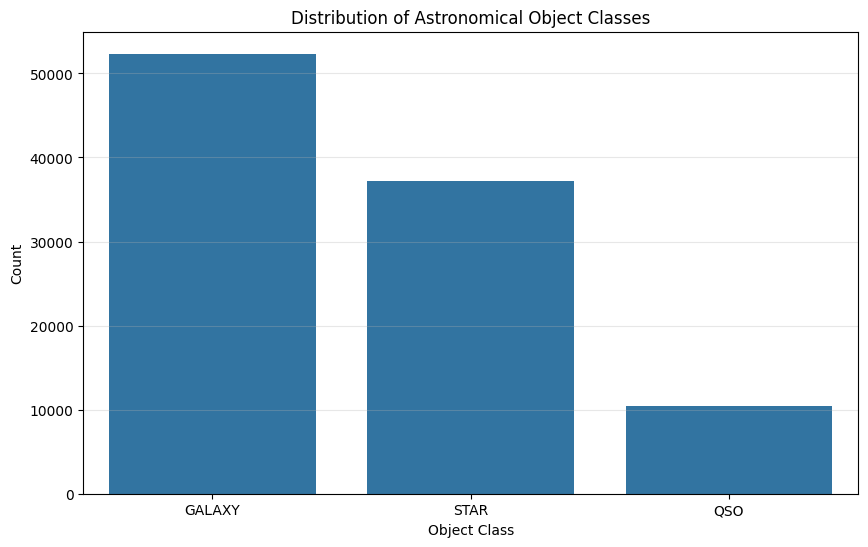


Applying preprocessing with PCA...

=== Astronomical Data Preprocessing Pipeline ===

Class distribution in training set:
  GALAXY: 36640 objects
  QSO: 7298 objects
  STAR: 26062 objects

Detecting and handling outliers in astronomical measurements...

Outlier Detection Statistics:
  2: 100 outliers (0.14%)
  3: 47 outliers (0.07%)
  4: 39 outliers (0.06%)
  5: 44 outliers (0.06%)
  6: 48 outliers (0.07%)
  11: 694 outliers (0.99%)
  14: 2466 outliers (3.52%)
  15: 534 outliers (0.76%)
  16: 647 outliers (0.92%)
  17: 549 outliers (0.78%)
  18: 919 outliers (1.31%)
  19: 3980 outliers (5.69%)
  20: 3719 outliers (5.31%)
  21: 3047 outliers (4.35%)
  22: 3185 outliers (4.55%)
  23: 2892 outliers (4.13%)
  24: 580 outliers (0.83%)
  25: 451 outliers (0.64%)
  26: 495 outliers (0.71%)
  27: 469 outliers (0.67%)
  28: 456 outliers (0.65%)
  30: 29 outliers (0.04%)
  31: 7 outliers (0.01%)
  32: 37 outliers (0.05%)
  33: 9 outliers (0.01%)
  37: 1 outliers (0.00%)
  38: 3 outliers (0.00%)

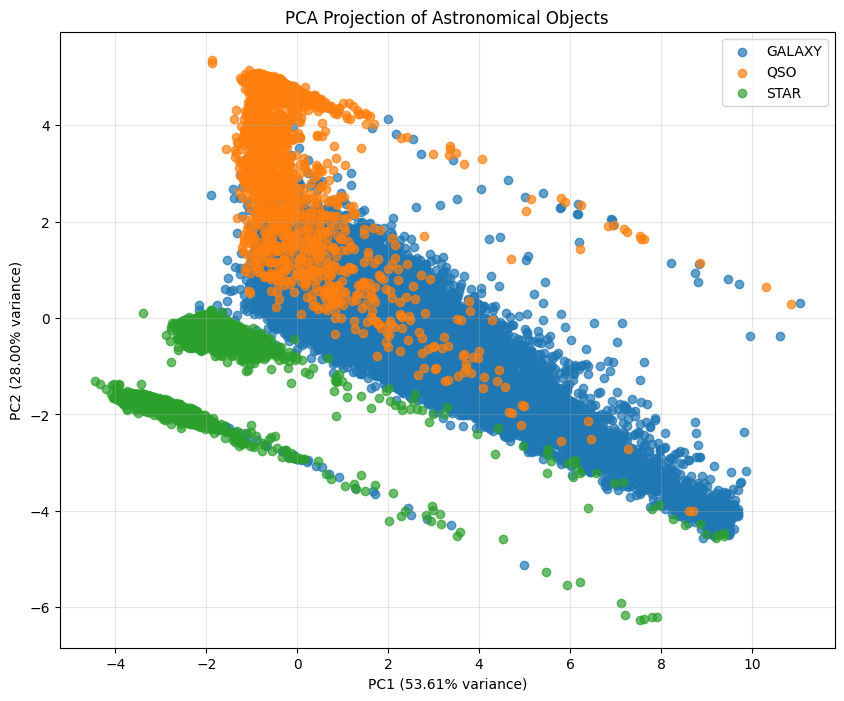


=== Preprocessing Complete! ===
Original features: 46
Selected features: 15

Applying preprocessing without PCA...

=== Astronomical Data Preprocessing Pipeline (No PCA) ===

Class distribution in training set:
  GALAXY: 36640 objects
  QSO: 7298 objects
  STAR: 26062 objects

Detecting and handling outliers in astronomical measurements...

Outlier Detection Statistics:
  2: 100 outliers (0.14%)
  3: 47 outliers (0.07%)
  4: 39 outliers (0.06%)
  5: 44 outliers (0.06%)
  6: 48 outliers (0.07%)
  11: 694 outliers (0.99%)
  14: 2466 outliers (3.52%)
  15: 534 outliers (0.76%)
  16: 647 outliers (0.92%)
  17: 549 outliers (0.78%)
  18: 919 outliers (1.31%)
  19: 3980 outliers (5.69%)
  20: 3719 outliers (5.31%)
  21: 3047 outliers (4.35%)
  22: 3185 outliers (4.55%)
  23: 2892 outliers (4.13%)
  24: 580 outliers (0.83%)
  25: 451 outliers (0.64%)
  26: 495 outliers (0.71%)
  27: 469 outliers (0.67%)
  28: 456 outliers (0.65%)
  30: 29 outliers (0.04%)
  31: 7 outliers (0.01%)
  32: 37 ou

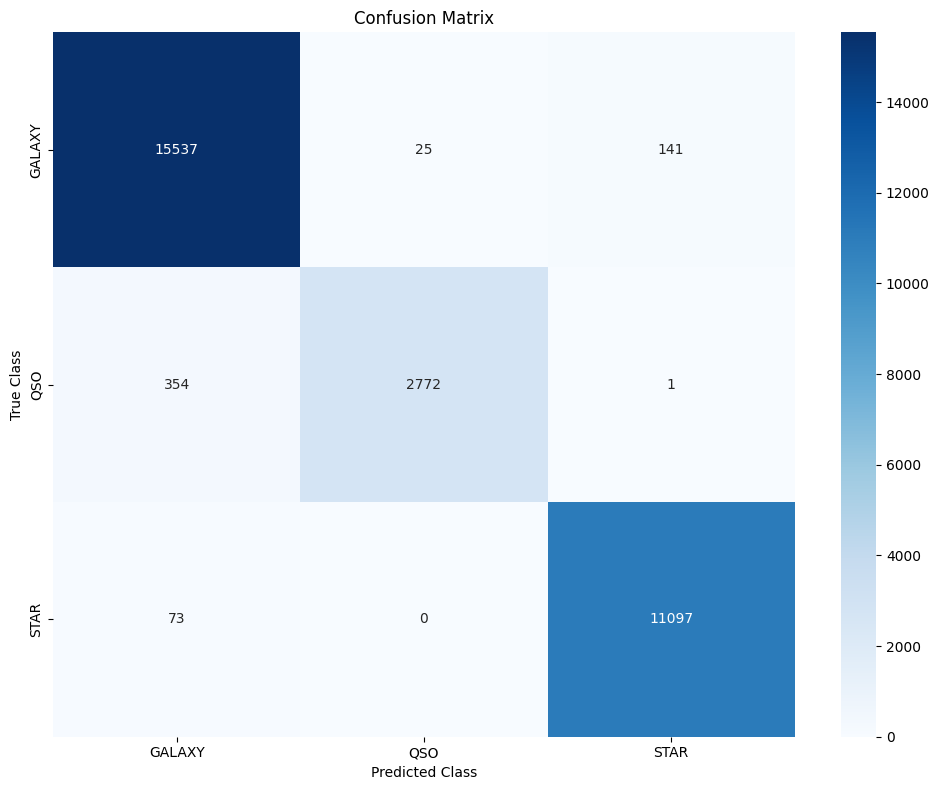


Classification Report:
              precision    recall  f1-score   support

      GALAXY       0.97      0.99      0.98     15703
         QSO       0.99      0.89      0.94      3127
        STAR       0.99      0.99      0.99     11170

    accuracy                           0.98     30000
   macro avg       0.98      0.96      0.97     30000
weighted avg       0.98      0.98      0.98     30000


Feature Importance:
       Feature  Importance
8    Feature_8    0.540198
0    Feature_0    0.417717
2    Feature_2    0.038788
13  Feature_13    0.002541
14  Feature_14    0.000420
3    Feature_3    0.000273
12  Feature_12    0.000062
6    Feature_6    0.000000
5    Feature_5    0.000000
4    Feature_4    0.000000
1    Feature_1    0.000000
10  Feature_10    0.000000
9    Feature_9    0.000000
7    Feature_7    0.000000
11  Feature_11    0.000000


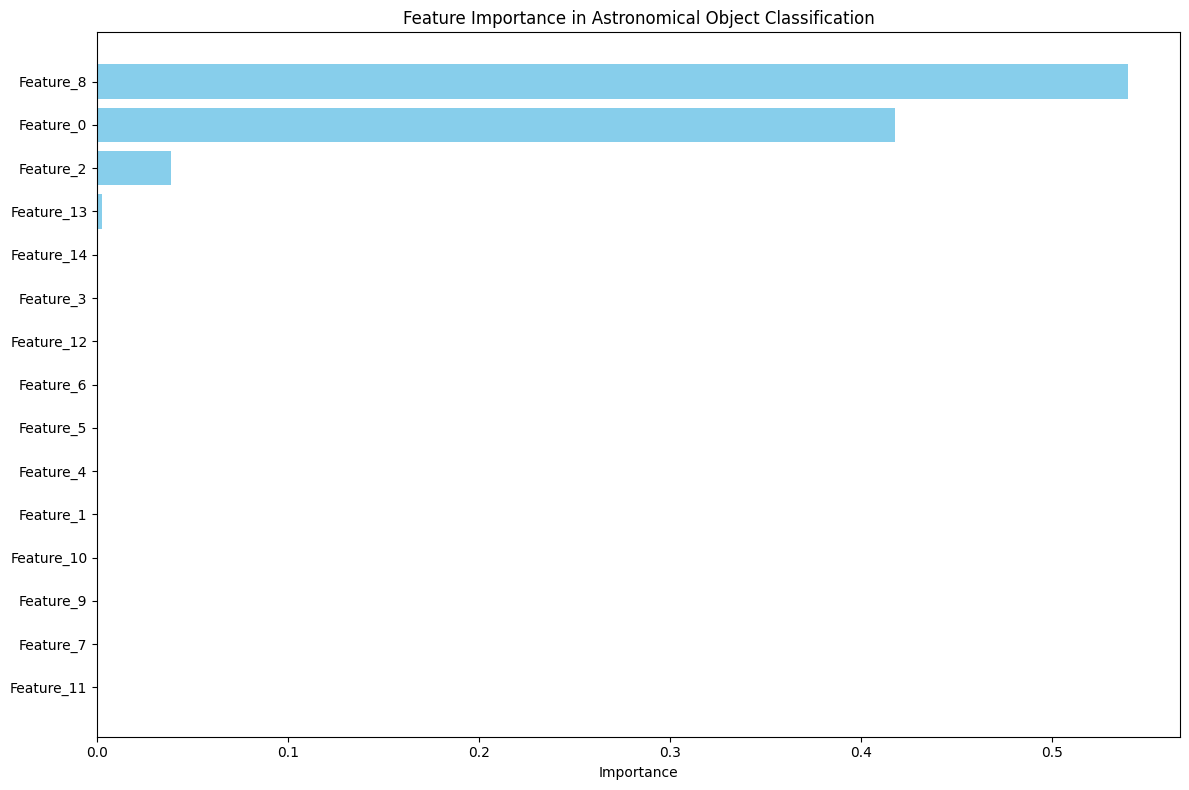


[2] VALIDATION MODEL: Training with enhanced validation...

Validating hyperparameters using validation set...
  Depth: 3, Min samples: 5, Validation Accuracy: 0.9646
  Depth: 3, Min samples: 10, Validation Accuracy: 0.9646
  Depth: 3, Min samples: 15, Validation Accuracy: 0.9646
  Depth: 3, Min samples: 20, Validation Accuracy: 0.9646
  Depth: 4, Min samples: 5, Validation Accuracy: 0.9814
  Depth: 4, Min samples: 10, Validation Accuracy: 0.9814
  Depth: 4, Min samples: 15, Validation Accuracy: 0.9814
  Depth: 4, Min samples: 20, Validation Accuracy: 0.9814
  Depth: 5, Min samples: 5, Validation Accuracy: 0.9814
  Depth: 5, Min samples: 10, Validation Accuracy: 0.9814
  Depth: 5, Min samples: 15, Validation Accuracy: 0.9814
  Depth: 5, Min samples: 20, Validation Accuracy: 0.9814
  Depth: 6, Min samples: 5, Validation Accuracy: 0.9834
  Depth: 6, Min samples: 10, Validation Accuracy: 0.9834
  Depth: 6, Min samples: 15, Validation Accuracy: 0.9834
  Depth: 6, Min samples: 20, Validati

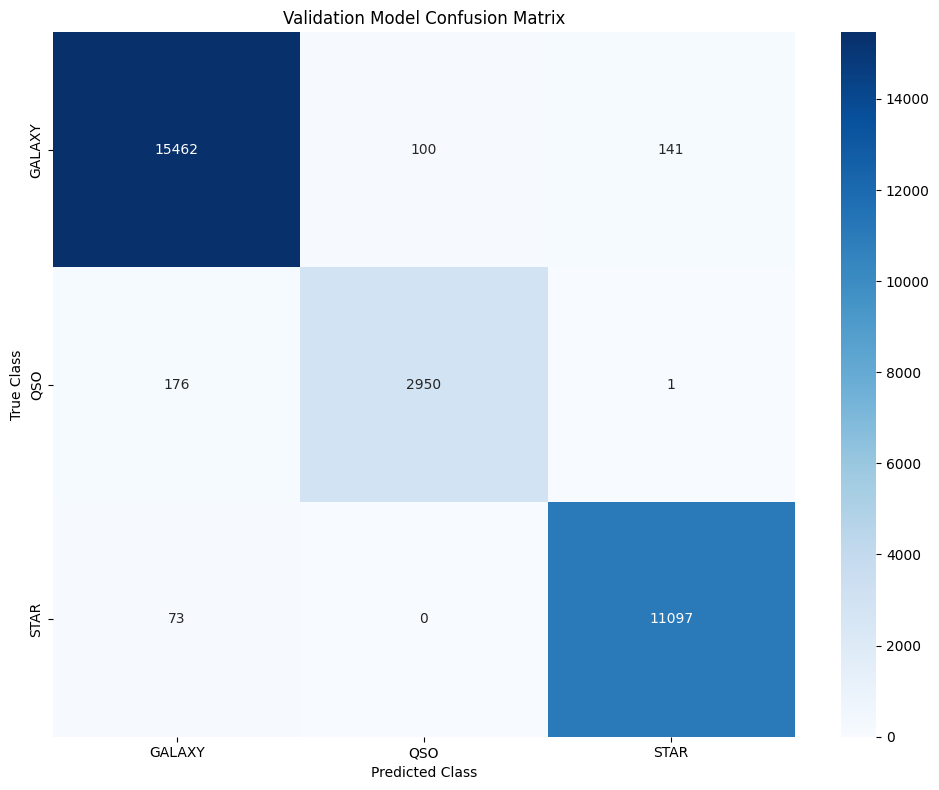


Validation Model Classification Report:
              precision    recall  f1-score   support

      GALAXY       0.98      0.98      0.98     15703
         QSO       0.97      0.94      0.96      3127
        STAR       0.99      0.99      0.99     11170

    accuracy                           0.98     30000
   macro avg       0.98      0.97      0.98     30000
weighted avg       0.98      0.98      0.98     30000


[3] CUSTOM GRID SEARCH MODEL: Optimizing with custom grid search...

Performing custom grid search (this may take a while)...

Starting Custom Grid Search for Astronomical Classification...
Parameter grid: {'criterion': ['gini', 'entropy'], 'max_depth': [4, 5, 6], 'min_sample_split': [5, 10, 15, 20], 'num_splits': [2]}
Total parameter combinations: 24

Evaluating combination 1/24: {'criterion': 'gini', 'max_depth': 4, 'min_sample_split': 5, 'num_splits': 2}
  Fold 1/5 - Accuracy: 0.9776
  Fold 2/5 - Accuracy: 0.9794
  Fold 3/5 - Accuracy: 0.9836
  Fold 4/5 - Accuracy: 0.

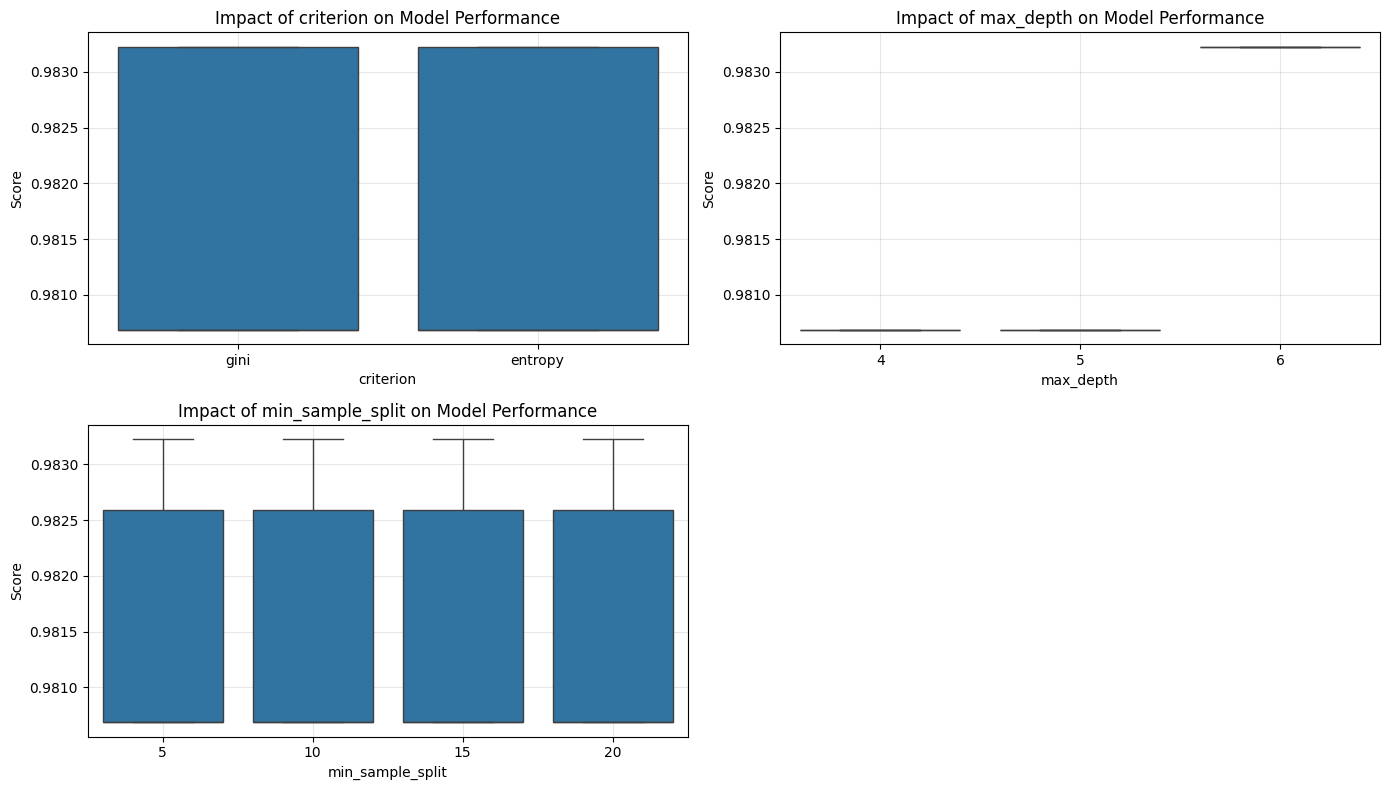

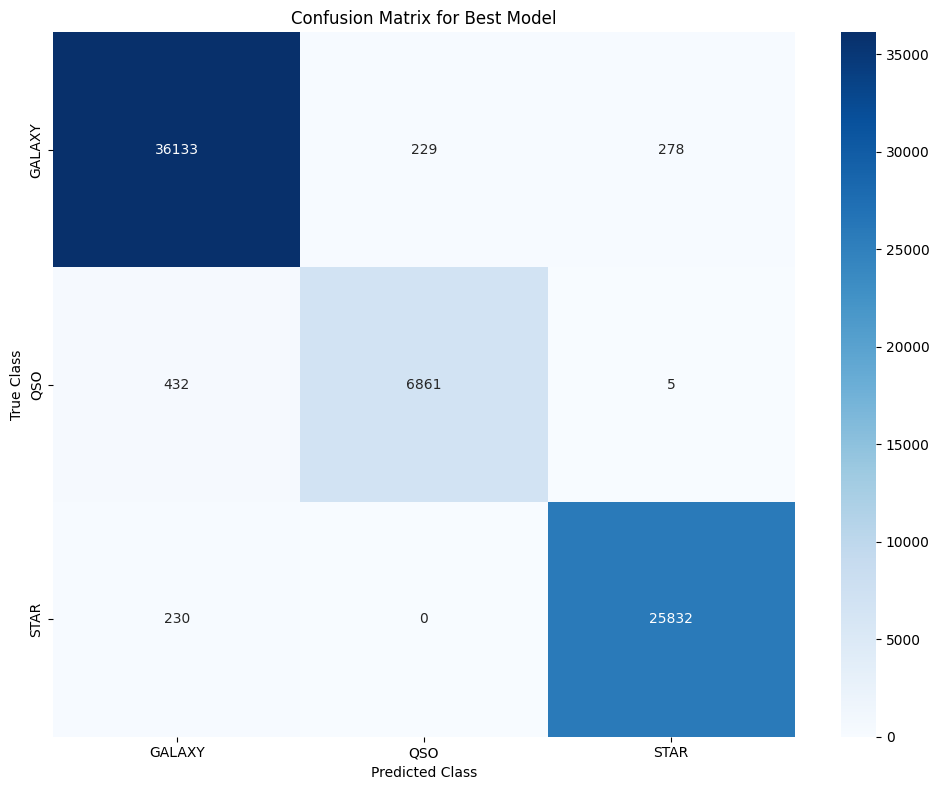

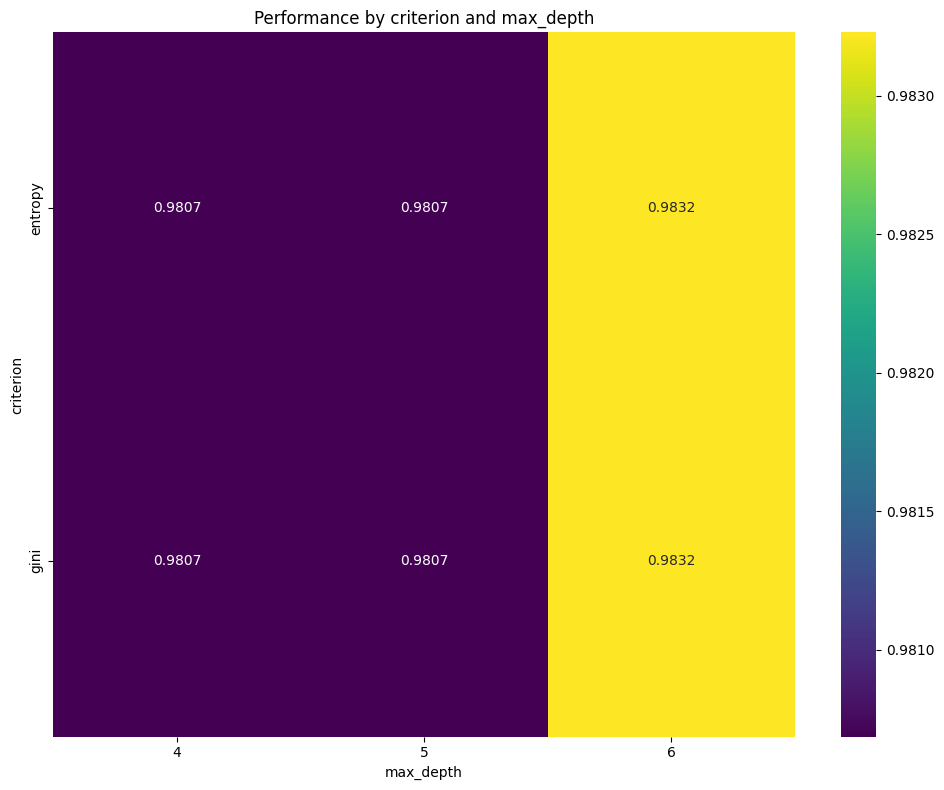

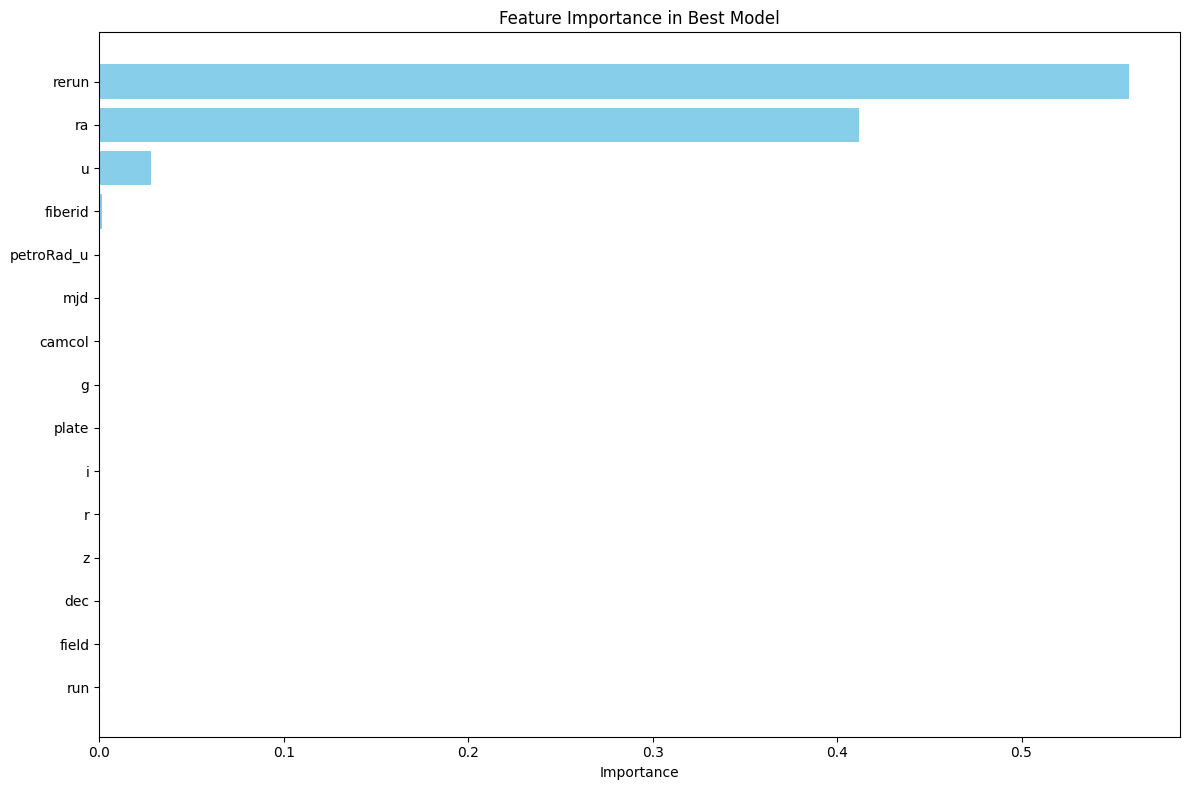

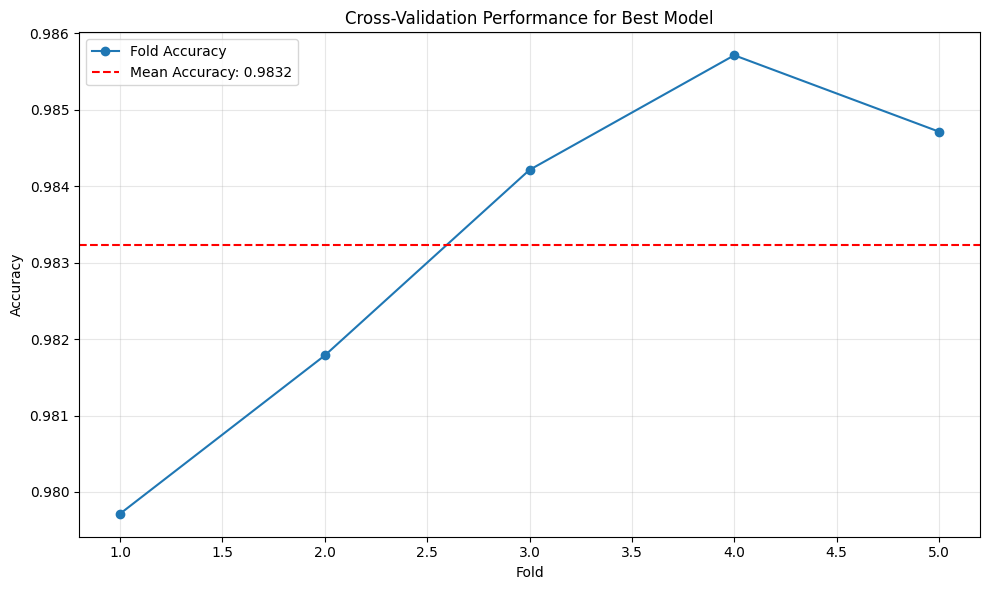


Custom Grid Search Results:
Best parameters: {'criterion': 'gini', 'max_depth': 6, 'min_sample_split': 5, 'num_splits': 2}
Best cross-validation score: 0.9832

Custom Grid Search Best Model Test Accuracy: 0.9836

Classification Report for Best Model:
              precision    recall  f1-score   support

      GALAXY       0.98      0.98      0.98     15703
         QSO       0.97      0.94      0.96      3127
        STAR       0.99      0.99      0.99     11170

    accuracy                           0.98     30000
   macro avg       0.98      0.97      0.98     30000
weighted avg       0.98      0.98      0.98     30000


Feature Importance from Custom Grid Search Best Model:
       Feature    Importance
8        rerun  5.580037e-01
0           ra  4.119659e-01
2            u  2.819983e-02
13     fiberid  1.415754e-03
14  petroRad_u  3.100187e-04
12         mjd  7.333451e-05
9       camcol  1.270154e-05
3            g  1.100526e-05
11       plate  5.645134e-06
5            i  1.519

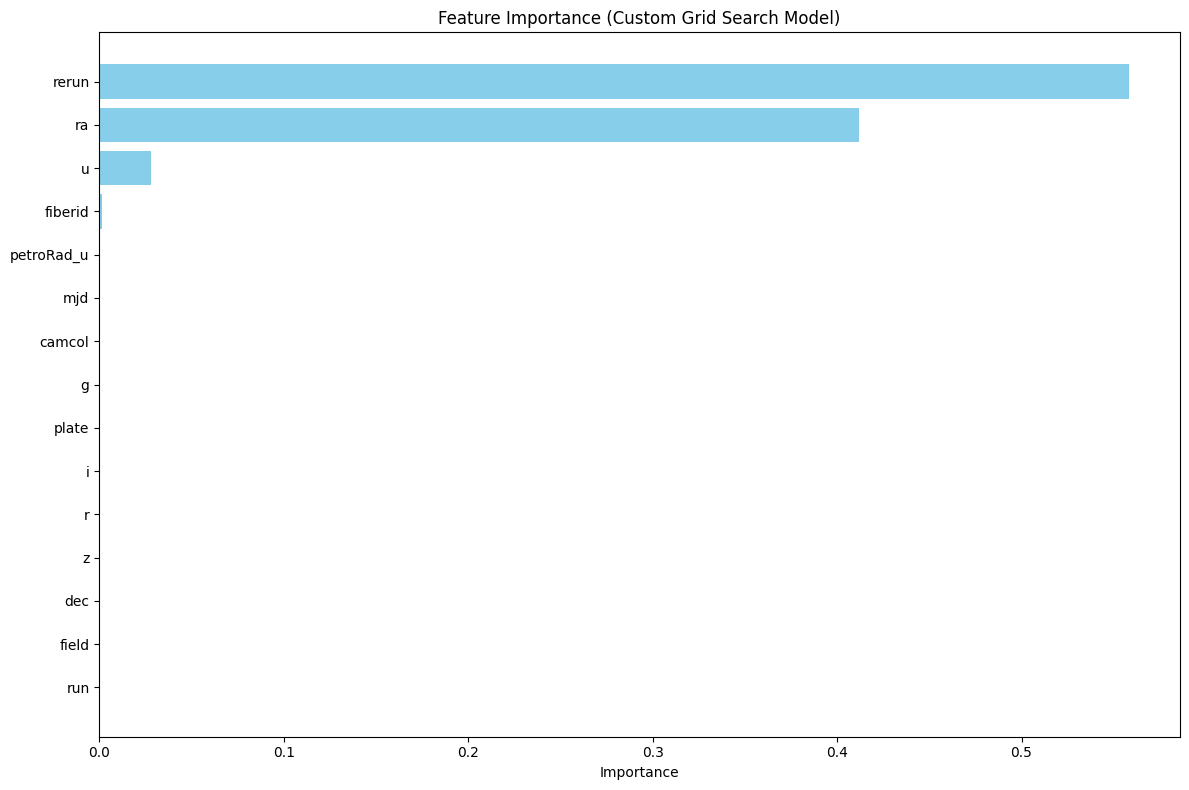


[4] NO-PCA MODEL: Training without dimensionality reduction...

Tuning No-PCA model parameters...

Starting Custom Grid Search for Astronomical Classification...
Parameter grid: {'criterion': ['gini'], 'max_depth': [6, 7], 'min_sample_split': [5], 'num_splits': [2]}
Total parameter combinations: 2

Evaluating combination 1/2: {'criterion': 'gini', 'max_depth': 6, 'min_sample_split': 5, 'num_splits': 2}
  Fold 1/5 - Accuracy: 0.9814
  Fold 2/5 - Accuracy: 0.9839
  Fold 3/5 - Accuracy: 0.9851
  Fold 4/5 - Accuracy: 0.9857
  Fold 5/5 - Accuracy: 0.9854
  Mean CV accuracy: 0.9843 ± 0.0016

Evaluating combination 2/2: {'criterion': 'gini', 'max_depth': 7, 'min_sample_split': 5, 'num_splits': 2}
  Fold 1/5 - Accuracy: 0.9861
  Fold 2/5 - Accuracy: 0.9852
  Fold 3/5 - Accuracy: 0.9872
  Fold 4/5 - Accuracy: 0.9856
  Fold 5/5 - Accuracy: 0.9869
  Mean CV accuracy: 0.9862 ± 0.0008

Grid Search Complete!
Best parameters: {'criterion': 'gini', 'max_depth': 7, 'min_sample_split': 5, 'num_splits':

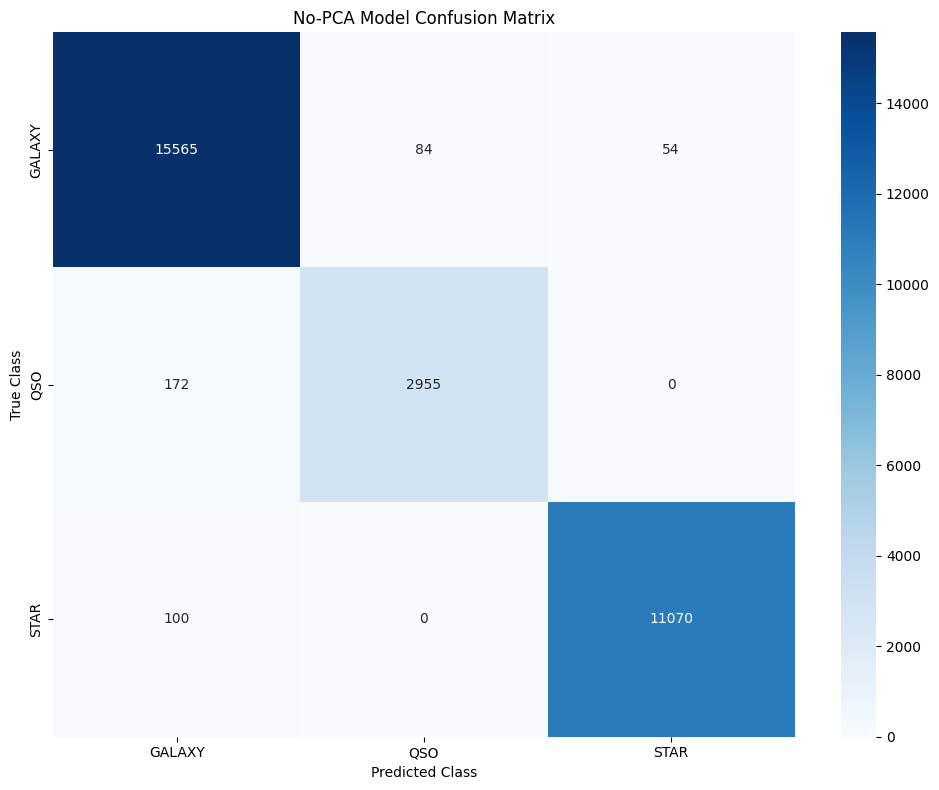


No-PCA Model Classification Report:
              precision    recall  f1-score   support

      GALAXY       0.98      0.99      0.99     15703
         QSO       0.97      0.94      0.96      3127
        STAR       1.00      0.99      0.99     11170

    accuracy                           0.99     30000
   macro avg       0.98      0.98      0.98     30000
weighted avg       0.99      0.99      0.99     30000


Feature Importance from No-PCA Model:
        Feature  Importance
8         rerun    0.480338
0            ra    0.425482
19  petroFlux_u    0.048956
2             u    0.025422
17   petroRad_r    0.010309
14   petroRad_u    0.008512
4             r    0.000470
13      fiberid    0.000242
9        camcol    0.000131
15   petroRad_g    0.000054


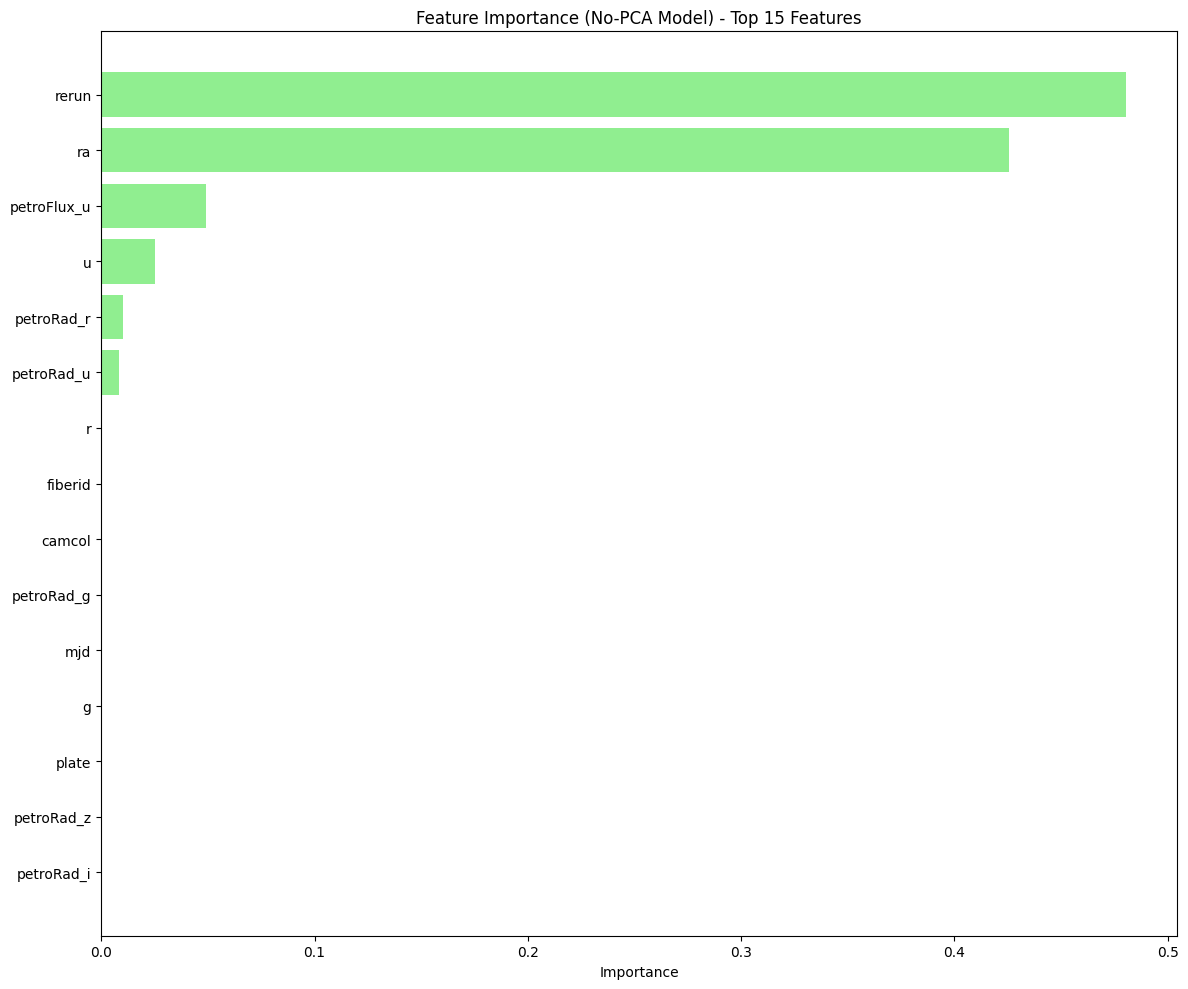


[5] MODEL COMPARISON: Comparing all models


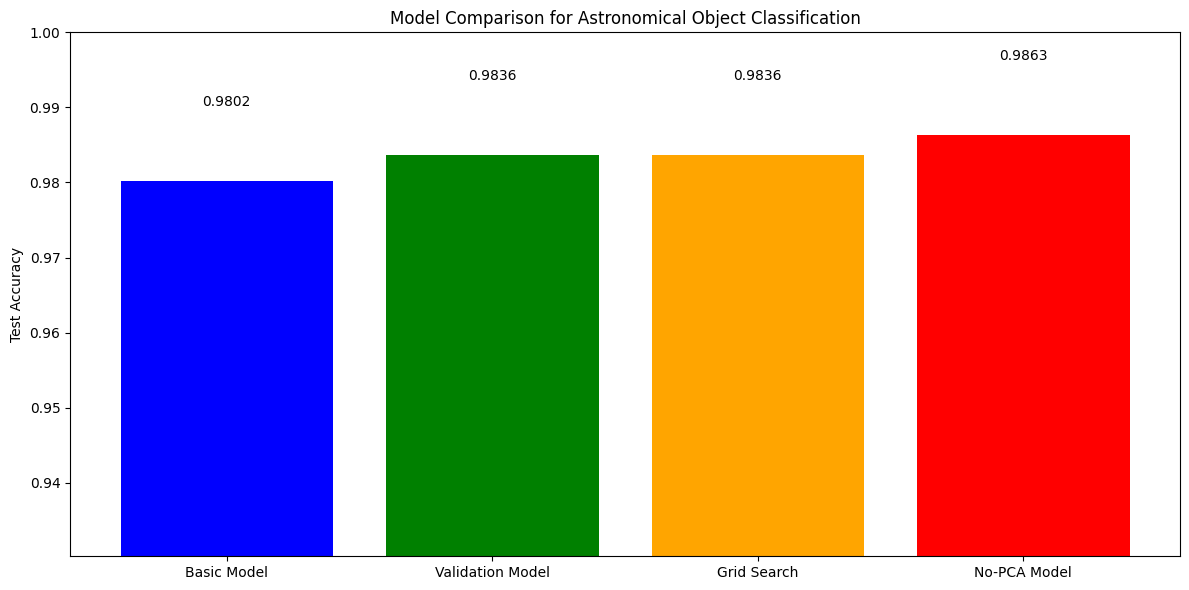


Model Agreement Analysis:
Agreement between Basic Model and Validation Model: 99.16%
Agreement between Basic Model and Grid Search: 99.16%
Agreement between Basic Model and No-PCA Model: 98.81%
Agreement between Validation Model and Grid Search: 100.00%
Agreement between Validation Model and No-PCA Model: 99.13%
Agreement between Grid Search and No-PCA Model: 99.13%

Samples correctly classified by No-PCA but misclassified by all PCA models: 117
Percentage of test set: 0.39%
Samples correctly classified by at least one PCA model but misclassified by No-PCA: 111
Percentage of test set: 0.37%

[6] PCA vs NO-PCA ANALYSIS

Dimensionality Reduction Summary:
Original dimensionality: 20 features
PCA-reduced dimensionality: 15 features
Dimensionality reduction: 25.0%
Theoretical computational speedup with PCA: 2.37x

Performance Comparison:
Best PCA model (Validation Model): 0.9836
No-PCA model: 0.9863
Accuracy difference: 0.0027 (0.27%)

For this astronomical dataset, PCA and No-PCA approach

<Figure size 1200x800 with 0 Axes>

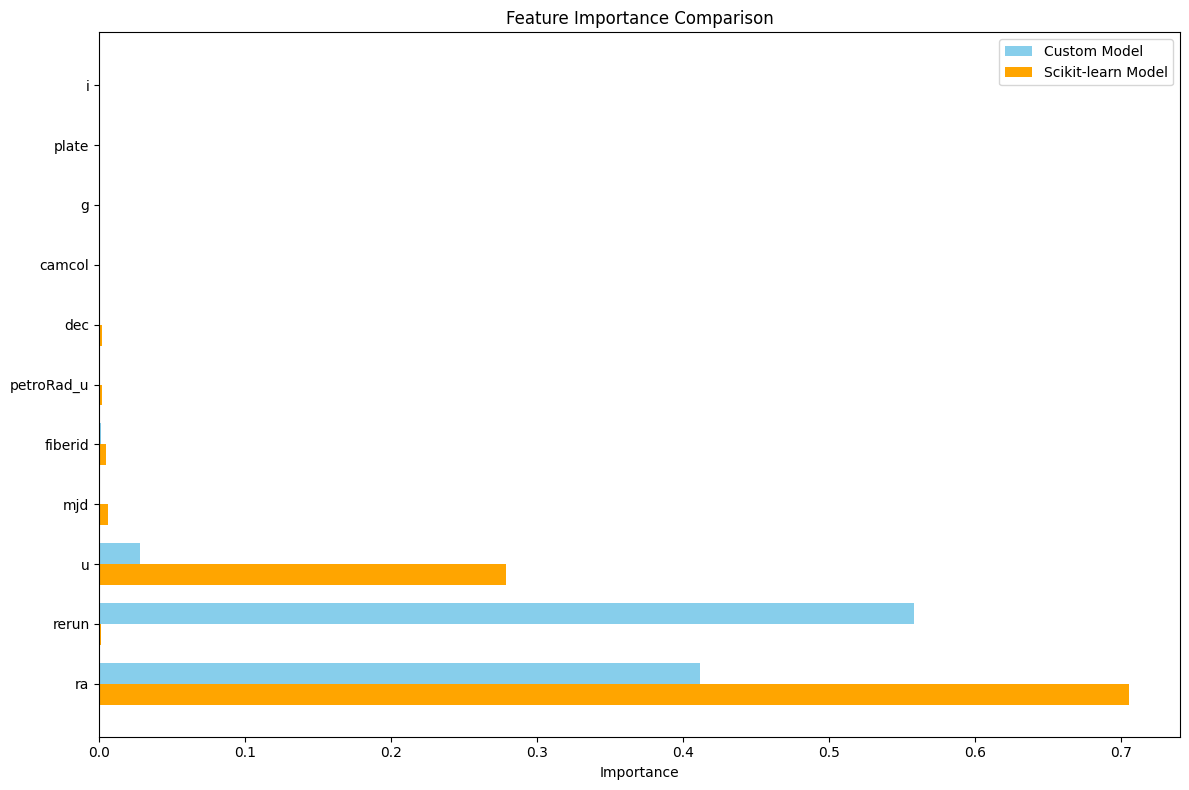

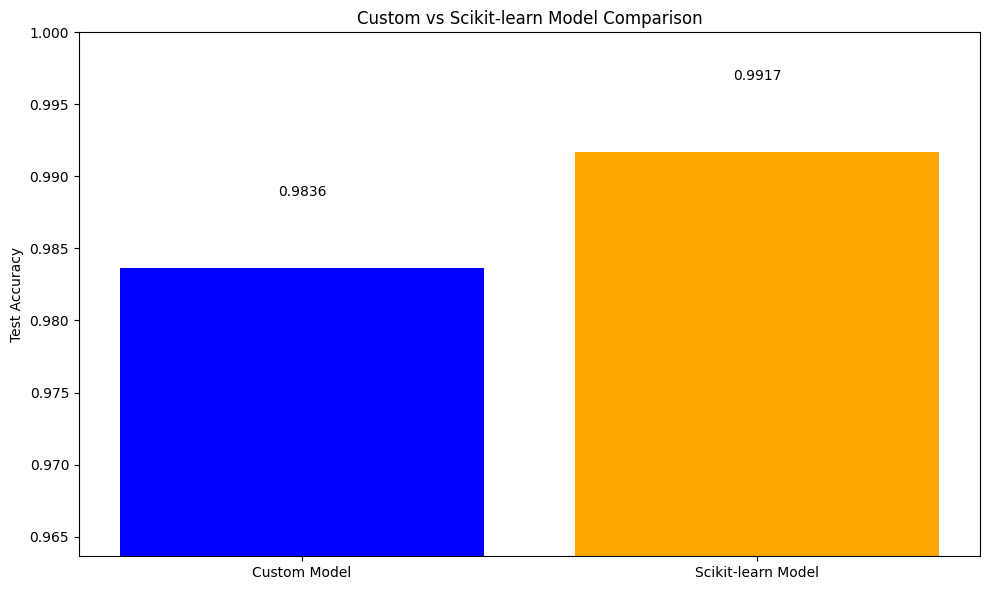


Generating learning curve for best model...


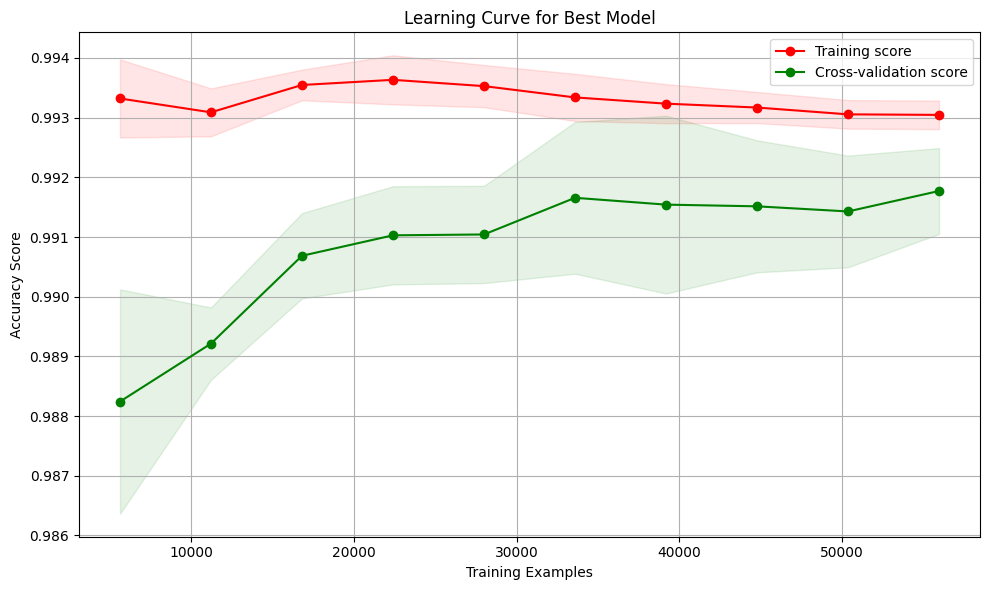


Detailed Performance Metrics Comparison:
                    Accuracy  Precision (weighted)  Recall (weighted)  \
Custom Model        0.983633              0.983582           0.983633   
Scikit-learn Model  0.991667              0.991640           0.991667   

                    F1 Score (weighted)  
Custom Model                   0.983589  
Scikit-learn Model             0.991605  


<Figure size 1200x600 with 0 Axes>

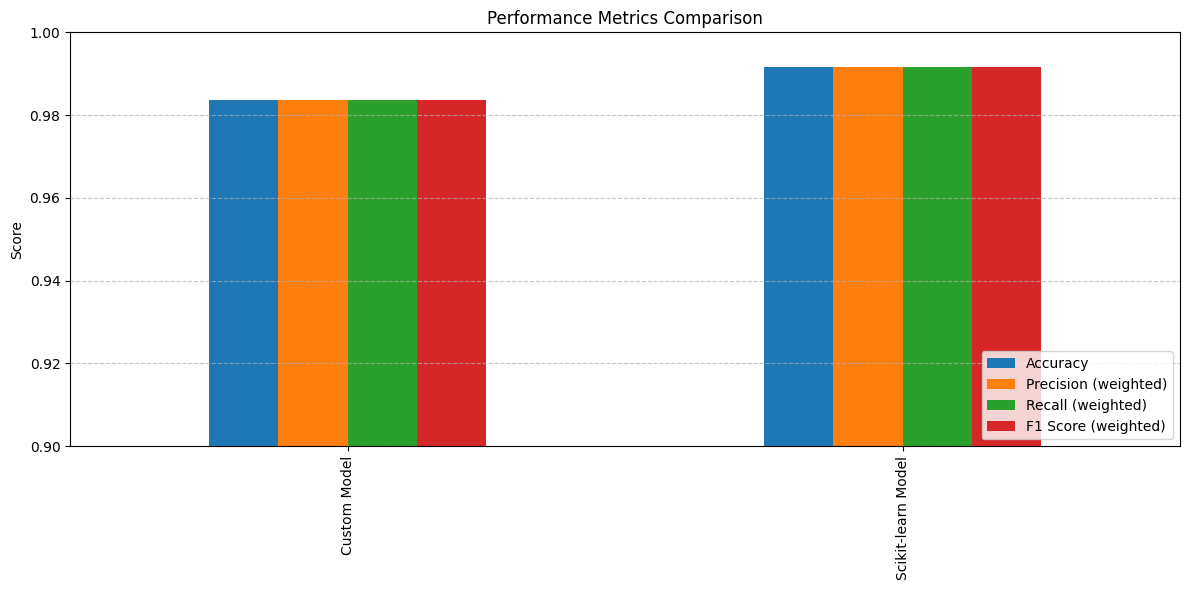


Model Agreement: 98.81% of test samples classified the same way

Generating Best Model Decision Tree Visualization...
Decision tree visualization saved as 'best_astronomical_decision_tree.pdf'

[8] UPDATED MODEL COMPARISON: All models including scikit-learn


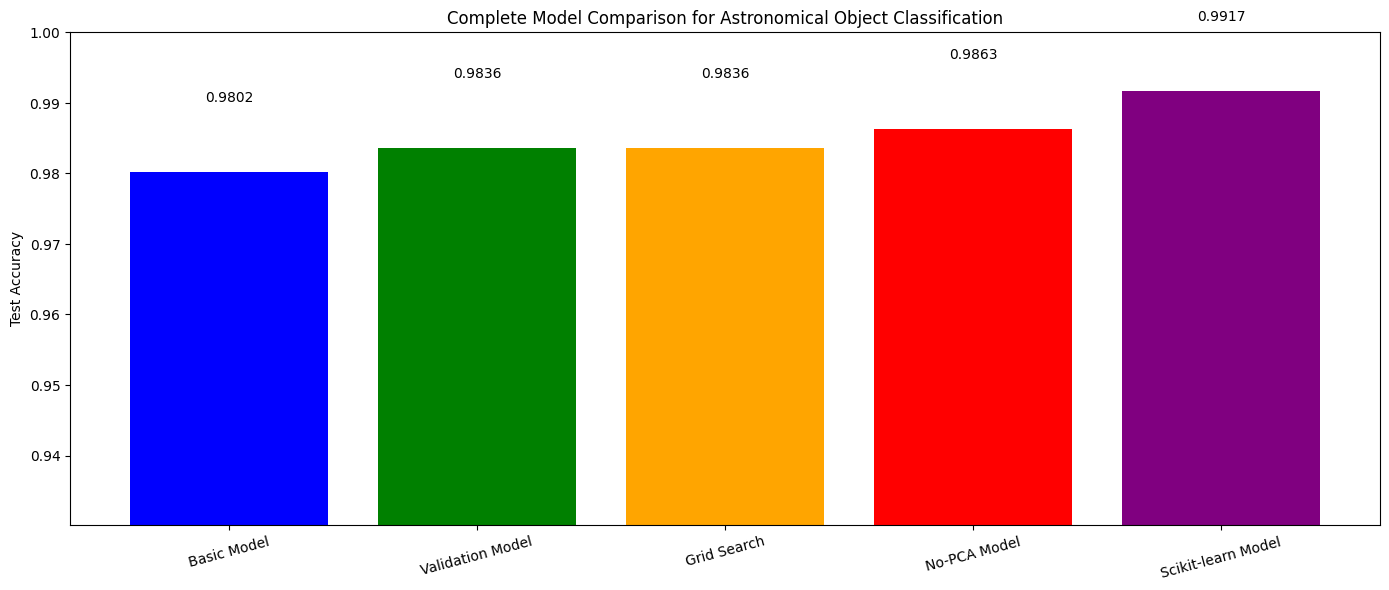


Final Recommendations:
Best overall model: Scikit-learn Model with accuracy 0.9917

Generating Best Model Decision Tree Visualization...
Decision tree visualization saved as 'best_astronomical_decision_tree.pdf'

Analysis Complete!


In [ ]:
def main(data_path="Dataset/SDSS_DR18.csv"):
    print("Astronomical Object Classification using Decision Trees")
    print("======================================================")
    
    data = load_and_explore_data(data_path)
    
    enhanced_data = engineer_astronomical_features(data)
    
    encoder = LabelEncoder()
    enhanced_data['class'] = encoder.fit_transform(enhanced_data['class'])
    class_names = list(encoder.classes_)
    
    X = enhanced_data.drop(['objid', 'specobjid', 'class'], axis=1).values
    y = enhanced_data['class'].values
    feature_names = enhanced_data.drop(['objid', 'specobjid', 'class'], axis=1).columns.tolist()
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    print("\nApplying preprocessing with PCA...")
    X_train_proc, X_test_proc, y_train, y_test, preproc_info = preprocess_astronomical_data(
        X_train, X_test, y_train, y_test, class_names
    )
    
    print("\nApplying preprocessing without PCA...")
    X_train_no_pca, X_test_no_pca, _, _, no_pca_info = preprocess_astronomical_data_no_pca(
        X_train, X_test, y_train, y_test, class_names
    )
    
    # 1. BASIC MODEL: Train custom decision tree
    print("\n[1] BASIC MODEL: Training custom decision tree classifier...")
    custom_tree = AstronomicalDecisionTree(
        min_sample_split=10, max_depth=4, num_splits=2
    )
    custom_tree.fit(X_train_proc, y_train)
    
    # Print tree structure
    print("\nDecision Tree Structure:")
    custom_tree.print_tree(feature_names=feature_names, class_names=class_names)
    
    # Evaluate model
    print("\nBasic Model Evaluation:")
    evaluate_tree_classifier(
        custom_tree, X_train_proc, y_train, X_test_proc, y_test, class_names
    )
    
    # 2. VALIDATION MODEL: Model with improved validation strategy
    print("\n[2] VALIDATION MODEL: Training with enhanced validation...")
    
    X_train_split, X_val, y_train_split, y_val = train_test_split(
        X_train_proc, y_train, test_size=0.2, random_state=42, stratify=y_train
    )
    
    best_depth = None
    best_min_samples = None
    best_val_accuracy = 0
    
    print("\nValidating hyperparameters using validation set...")
    depths = [3, 4, 5, 6]
    min_samples = [5, 10, 15, 20]
    
    for depth in depths:
        for min_sample in min_samples:
            val_tree = AstronomicalDecisionTree(
                min_sample_split=min_sample, 
                max_depth=depth, 
                num_splits=2
            )
            val_tree.fit(X_train_split, y_train_split)
            val_accuracy = accuracy_score(y_val, val_tree.predict(X_val))
            
            print(f"  Depth: {depth}, Min samples: {min_sample}, Validation Accuracy: {val_accuracy:.4f}")
            
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                best_depth = depth
                best_min_samples = min_sample
    
    print(f"\nBest validation parameters: depth={best_depth}, min_samples={best_min_samples}")
    print(f"Best validation accuracy: {best_val_accuracy:.4f}")
    
    final_val_tree = AstronomicalDecisionTree(
        min_sample_split=best_min_samples, 
        max_depth=best_depth, 
        num_splits=2
    )
    final_val_tree.fit(X_train_proc, y_train)
    
    val_test_pred = final_val_tree.predict(X_test_proc)
    val_test_accuracy = accuracy_score(y_test, val_test_pred)
    
    print(f"\nValidation Model Test Accuracy: {val_test_accuracy:.4f}")
    
    val_conf_matrix = confusion_matrix(y_test, val_test_pred)
    print("\nValidation Model Confusion Matrix:")
    print(val_conf_matrix)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues',
               xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.title('Validation Model Confusion Matrix')
    plt.tight_layout()
    plt.show()
    
    print("\nValidation Model Classification Report:")
    print(classification_report(y_test, val_test_pred, target_names=class_names))
    
    # 3. CUSTOM GRID SEARCH MODEL: Model with custom hyperparameter tuning

    print("\n[3] CUSTOM GRID SEARCH MODEL: Optimizing with custom grid search...")
    
    param_grid = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [4,5,6],
        'min_sample_split': [5, 10, 15, 20],
        'num_splits': [2]
    }
    
    print("\nPerforming custom grid search (this may take a while)...")
    grid_search_results = custom_grid_search(
        model_class=AstronomicalDecisionTree,
        param_grid=param_grid,
        X_train=X_train_proc, 
        y_train=y_train,
        cv=5,
        scoring='accuracy',
        verbose=True,
        class_names=class_names
    )
    
    custom_grid_search_visualize_results(
        grid_search_results, 
        feature_names=feature_names[:X_train_proc.shape[1]], 
        class_names=class_names
    )
    
    best_model = grid_search_results['best_model']
    best_params = grid_search_results['best_params']
    best_score = grid_search_results['best_score']
    
    print("\nCustom Grid Search Results:")
    print(f"Best parameters: {best_params}")
    print(f"Best cross-validation score: {best_score:.4f}")
    
    gs_test_pred = best_model.predict(X_test_proc)
    gs_test_accuracy = accuracy_score(y_test, gs_test_pred)
    print(f"\nCustom Grid Search Best Model Test Accuracy: {gs_test_accuracy:.4f}")
    
    print("\nClassification Report for Best Model:")
    print(classification_report(y_test, gs_test_pred, target_names=class_names))
    
    if hasattr(best_model, 'get_feature_importance'):
        print("\nFeature Importance from Custom Grid Search Best Model:")
        importance_df = best_model.get_feature_importance(feature_names[:X_train_proc.shape[1]])
        print(importance_df)
        
        plt.figure(figsize=(12, 8))
        plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
        plt.xlabel('Importance')
        plt.title('Feature Importance (Custom Grid Search Model)')
        plt.gca().invert_yaxis()  # Highest importance at top
        plt.tight_layout()
        plt.show()
    
    # 4. NO-PCA MODEL: Training a model without PCA dimensionality reduction

    print("\n[4] NO-PCA MODEL: Training without dimensionality reduction...")
    
    no_pca_param_grid = {
        'criterion': [best_params['criterion']],
        'max_depth': [best_params['max_depth'], best_params['max_depth']+1],  # Potentially deeper trees
        'min_sample_split': [best_params['min_sample_split']],
        'num_splits': [best_params['num_splits']]
    }
    
    print("\nTuning No-PCA model parameters...")
    no_pca_grid_results = custom_grid_search(
        model_class=AstronomicalDecisionTree,
        param_grid=no_pca_param_grid,
        X_train=X_train_no_pca, 
        y_train=y_train,
        cv=5,
        scoring='accuracy',
        verbose=True,
        class_names=class_names
    )
    
    no_pca_best_model = no_pca_grid_results['best_model']
    no_pca_best_params = no_pca_grid_results['best_params']
    no_pca_best_score = no_pca_grid_results['best_score']
    
    print("\nNo-PCA Model Best Parameters:")
    print(f"Parameters: {no_pca_best_params}")
    print(f"Cross-validation score: {no_pca_best_score:.4f}")
    
    no_pca_test_pred = no_pca_best_model.predict(X_test_no_pca)
    no_pca_test_accuracy = accuracy_score(y_test, no_pca_test_pred)
    print(f"\nNo-PCA Model Test Accuracy: {no_pca_test_accuracy:.4f}")
    
    no_pca_conf_matrix = confusion_matrix(y_test, no_pca_test_pred)
    print("\nNo-PCA Model Confusion Matrix:")
    print(no_pca_conf_matrix)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(no_pca_conf_matrix, annot=True, fmt='d', cmap='Blues',
               xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.title('No-PCA Model Confusion Matrix')
    plt.tight_layout()
    plt.show()
    
    print("\nNo-PCA Model Classification Report:")
    print(classification_report(y_test, no_pca_test_pred, target_names=class_names))
    
    if hasattr(no_pca_best_model, 'get_feature_importance'):
        print("\nFeature Importance from No-PCA Model:")
        no_pca_importance_df = no_pca_best_model.get_feature_importance(
            feature_names[:X_train_no_pca.shape[1]]
        )
        print(no_pca_importance_df.head(10)) 
        
        plt.figure(figsize=(12, 10))
        top_features = no_pca_importance_df.head(15)
        plt.barh(top_features['Feature'], top_features['Importance'], color='lightgreen')
        plt.xlabel('Importance')
        plt.title('Feature Importance (No-PCA Model) - Top 15 Features')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
    
    #-----------------------------------------------------------------------
    # 5. MODEL COMPARISON: Compare all models including No-PCA model
    #-----------------------------------------------------------------------
    print("\n[5] MODEL COMPARISON: Comparing all models")
    
    # Get accuracies for all models
    basic_accuracy = accuracy_score(y_test, custom_tree.predict(X_test_proc))
    val_accuracy = val_test_accuracy
    gs_accuracy = gs_test_accuracy
    no_pca_accuracy = no_pca_test_accuracy
    
    plt.figure(figsize=(12, 6))
    models = ['Basic Model', 'Validation Model', 'Grid Search', 'No-PCA Model']
    accuracies = [basic_accuracy, val_accuracy, gs_accuracy, no_pca_accuracy]
    
    colors = ['blue', 'green', 'orange', 'red']
    
    plt.bar(models, accuracies, color=colors)
    plt.ylim(max(0.8, min(accuracies) - 0.05), min(1.0, max(accuracies) + 0.05))
    plt.ylabel('Test Accuracy')
    plt.title('Model Comparison for Astronomical Object Classification')
    
    for i, v in enumerate(accuracies):
        plt.text(i, v + 0.01, f'{v:.4f}', ha='center')
    
    plt.tight_layout()
    plt.show()
    
    predictions = {
        'Basic Model': custom_tree.predict(X_test_proc),
        'Validation Model': final_val_tree.predict(X_test_proc),
        'Grid Search Model': best_model.predict(X_test_proc),
        'No-PCA Model': no_pca_test_pred
    }
    
    print("\nModel Agreement Analysis:")
    for i, model1 in enumerate(models):
        for j, model2 in enumerate(models):
            if i < j:  # Only compare each pair once
                model1_key = model1 if model1 in predictions else f"{model1} Model"
                model2_key = model2 if model2 in predictions else f"{model2} Model" 
                agreement = np.mean(predictions[model1_key] == predictions[model2_key]) * 100
                print(f"Agreement between {model1} and {model2}: {agreement:.2f}%")
    
    pca_models_wrong = np.logical_and.reduce([
        predictions['Basic Model'] != y_test,
        predictions['Validation Model'] != y_test,
        predictions['Grid Search Model'] != y_test
    ])
    no_pca_correct = predictions['No-PCA Model'] == y_test
    
    better_with_no_pca = np.logical_and(pca_models_wrong, no_pca_correct)
    num_better_with_no_pca = np.sum(better_with_no_pca)
    
    print(f"\nSamples correctly classified by No-PCA but misclassified by all PCA models: {num_better_with_no_pca}")
    print(f"Percentage of test set: {num_better_with_no_pca/len(y_test)*100:.2f}%")
    
    pca_models_correct = np.logical_or.reduce([
        predictions['Basic Model'] == y_test,
        predictions['Validation Model'] == y_test,
        predictions['Grid Search Model'] == y_test
    ])
    no_pca_wrong = predictions['No-PCA Model'] != y_test
    
    better_with_pca = np.logical_and(pca_models_correct, no_pca_wrong)
    num_better_with_pca = np.sum(better_with_pca)
    
    print(f"Samples correctly classified by at least one PCA model but misclassified by No-PCA: {num_better_with_pca}")
    print(f"Percentage of test set: {num_better_with_pca/len(y_test)*100:.2f}%")
    
    #-----------------------------------------------------------------------
    # 6. PCA vs NO-PCA ANALYSIS
    #-----------------------------------------------------------------------
    print("\n[6] PCA vs NO-PCA ANALYSIS")
    
    # Calculate dimensionality reduction metrics
    original_dims = X_train_no_pca.shape[1]
    reduced_dims = X_train_proc.shape[1]
    dim_reduction_ratio = (original_dims - reduced_dims) / original_dims * 100
    
    print(f"\nDimensionality Reduction Summary:")
    print(f"Original dimensionality: {original_dims} features")
    print(f"PCA-reduced dimensionality: {reduced_dims} features")
    print(f"Dimensionality reduction: {dim_reduction_ratio:.1f}%")

    # Time complexity O(n^3) for tree with n features vs O(k^3) for k < n
    theoretical_speedup = (original_dims / reduced_dims) ** 3
    print(f"Theoretical computational speedup with PCA: {theoretical_speedup:.2f}x")
    
    print("\nPerformance Comparison:")
    best_pca_model_acc = max(basic_accuracy, val_accuracy, gs_accuracy)
    best_pca_model_name = models[np.argmax([basic_accuracy, val_accuracy, gs_accuracy])]
    
    acc_diff = no_pca_accuracy - best_pca_model_acc
    
    print(f"Best PCA model ({best_pca_model_name}): {best_pca_model_acc:.4f}")
    print(f"No-PCA model: {no_pca_accuracy:.4f}")
    print(f"Accuracy difference: {acc_diff:.4f} ({acc_diff*100:.2f}%)")
    
    
    print("\n[7] SCIKIT-LEARN COMPARISON: Comparing with scikit-learn implementation")
    
    print("\nTraining scikit-learn decision tree with grid search...")
    start_time = time.time()
    
    # Define parameter grid for scikit-learn
    sklearn_param_grid = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [4, 5, 6],
        'min_samples_split': [5, 10, 15, 20],
        'class_weight': [None, 'balanced']
    }
    
    sklearn_grid_search = GridSearchCV(
        DecisionTreeClassifier(random_state=42),
        param_grid=sklearn_param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )
    
    sklearn_grid_search.fit(X_train_proc, y_train)
    sklearn_train_time = time.time() - start_time
    
    sklearn_best_model = sklearn_grid_search.best_estimator_
    sklearn_best_params = sklearn_grid_search.best_params_
    sklearn_best_score = sklearn_grid_search.best_score_
    
    print(f"\nScikit-learn Grid Search Time: {sklearn_train_time:.2f} seconds")
    print(f"Best parameters: {sklearn_best_params}")
    print(f"Best cross-validation score: {sklearn_best_score:.4f}")
    
    sklearn_test_pred = sklearn_best_model.predict(X_test_proc)
    sklearn_test_accuracy = accuracy_score(y_test, sklearn_test_pred)
    print(f"\nScikit-learn Best Model Test Accuracy: {sklearn_test_accuracy:.4f}")
    
    print("\nScikitlearn Classification Report:")
    print(classification_report(y_test, sklearn_test_pred, target_names=class_names))
    
    print("\nScikit-learn Feature Importance:")
    sklearn_importances = sklearn_best_model.feature_importances_
    sklearn_importance_df = pd.DataFrame({
        'Feature': feature_names[:X_train_proc.shape[1]],
        'Importance': sklearn_importances
    }).sort_values(by='Importance', ascending=False)
    
    print(sklearn_importance_df.head(10))
    
    plt.figure(figsize=(12, 8))
    
    top_features_sklearn = sklearn_importance_df.head(10)['Feature'].tolist()
    
    custom_importance_df = best_model.get_feature_importance(feature_names[:X_train_proc.shape[1]])
    top_features_custom = custom_importance_df.head(10)['Feature'].tolist()
    
    top_features = list(set(top_features_sklearn + top_features_custom))
    
    sklearn_imp_dict = dict(zip(sklearn_importance_df['Feature'], sklearn_importance_df['Importance']))
    custom_imp_dict = dict(zip(custom_importance_df['Feature'], custom_importance_df['Importance']))
    
    # Get importance values for the top features
    sklearn_values = [sklearn_imp_dict.get(feature, 0) for feature in top_features]
    custom_values = [custom_imp_dict.get(feature, 0) for feature in top_features]
    
    # Sort by average importance
    avg_importance = [(s + c) / 2 for s, c in zip(sklearn_values, custom_values)]
    sorted_indices = np.argsort(avg_importance)
    top_features = [top_features[i] for i in sorted_indices]
    sklearn_values = [sklearn_values[i] for i in sorted_indices]
    custom_values = [custom_values[i] for i in sorted_indices]
    
    # Plot
    x = np.arange(len(top_features))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.barh(x - width/2, custom_values, width, label='Custom Model', color='skyblue')
    ax.barh(x + width/2, sklearn_values, width, label='Scikit-learn Model', color='orange')
    
    ax.set_yticks(x)
    ax.set_yticklabels(top_features)
    ax.invert_yaxis()
    ax.set_xlabel('Importance')
    ax.set_title('Feature Importance Comparison')
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    custom_accuracy = accuracy_score(y_test, best_model.predict(X_test_proc))
    
    plt.figure(figsize=(10, 6))
    models_compare = ['Custom Model', 'Scikit-learn Model']
    accuracies_compare = [custom_accuracy, sklearn_test_accuracy]
    
    plt.bar(models_compare, accuracies_compare, color=['blue', 'orange'])
    plt.ylim(max(0.90, min(accuracies_compare) - 0.02), min(1.0, max(accuracies_compare) + 0.02))
    plt.ylabel('Test Accuracy')
    plt.title('Custom vs Scikit-learn Model Comparison')
    
    for i, v in enumerate(accuracies_compare):
        plt.text(i, v + 0.005, f'{v:.4f}', ha='center')
    
    plt.tight_layout()
    plt.show()
    
    print("\nGenerating learning curve for best model...")
    
    train_sizes = np.linspace(0.1, 1.0, 10)
    
    train_sizes, train_scores, test_scores = learning_curve(
        sklearn_best_model, X_train_proc, y_train,
        train_sizes=train_sizes, cv=5, scoring='accuracy',
        n_jobs=-1, shuffle=True, random_state=42
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.grid()
    
    plt.fill_between(train_sizes, train_mean - train_std,
                     train_mean + train_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_mean - test_std,
                     test_mean + test_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.title("Learning Curve for Best Model")
    plt.xlabel("Training Examples")
    plt.ylabel("Accuracy Score")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()
    
    from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
    
    metrics = {
        'Accuracy': [custom_accuracy, sklearn_test_accuracy],
        'Precision (weighted)': [
            precision_score(y_test, best_model.predict(X_test_proc), average='weighted'),
            precision_score(y_test, sklearn_test_pred, average='weighted')
        ],
        'Recall (weighted)': [
            recall_score(y_test, best_model.predict(X_test_proc), average='weighted'),
            recall_score(y_test, sklearn_test_pred, average='weighted')
        ],
        'F1 Score (weighted)': [
            f1_score(y_test, best_model.predict(X_test_proc), average='weighted'),
            f1_score(y_test, sklearn_test_pred, average='weighted')
        ],
    }
    
    metrics_df = pd.DataFrame(metrics, index=['Custom Model', 'Scikit-learn Model'])
    print("\nDetailed Performance Metrics Comparison:")
    print(metrics_df)
    
    plt.figure(figsize=(12, 6))
    metrics_df.plot(kind='bar', figsize=(12, 6))
    plt.title('Performance Metrics Comparison')
    plt.ylabel('Score')
    plt.ylim(0.9, 1.0)  
    plt.legend(loc='lower right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    agreement = np.mean(best_model.predict(X_test_proc) == sklearn_test_pred) * 100
    print(f"\nModel Agreement: {agreement:.2f}% of test samples classified the same way")
    
    print("\nGenerating Best Model Decision Tree Visualization...")
    save_decision_tree_visualization(
        best_model, 
        feature_names[:X_train_proc.shape[1]], 
        class_names, 
        output_filename='best_astronomical_decision_tree.pdf'
    )
    
    print("\n[8] UPDATED MODEL COMPARISON: All models including scikit-learn")
    
    all_models = models + ['Scikit-learn Model']
    all_accuracies = accuracies + [sklearn_test_accuracy]
    all_colors = colors + ['purple']
    
    plt.figure(figsize=(14, 6))
    plt.bar(all_models, all_accuracies, color=all_colors)
    plt.ylim(max(0.8, min(all_accuracies) - 0.05), min(1.0, max(all_accuracies) + 0.05))
    plt.ylabel('Test Accuracy')
    plt.title('Complete Model Comparison for Astronomical Object Classification')
    plt.xticks(rotation=15)
    
    for i, v in enumerate(all_accuracies):
        plt.text(i, v + 0.01, f'{v:.4f}', ha='center')
    
    plt.tight_layout()
    plt.show()
    
    print("\nFinal Recommendations:")
    
    best_overall_acc = max(all_accuracies)
    best_overall_model = all_models[np.argmax(all_accuracies)]
    
    print(f"Best overall model: {best_overall_model} with accuracy {best_overall_acc:.4f}")

    print("\nGenerating Best Model Decision Tree Visualization...")
    save_decision_tree_visualization(
        best_model, 
        feature_names[:X_train_proc.shape[1]], 
        class_names, 
        output_filename='best_astronomical_decision_tree.pdf'
    )

    print("\nAnalysis Complete!")

if __name__ == "__main__":
    main()

# TASK SECTION

# task 1 

Download a dataset from the Kaggle website and clean the dataset.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

def clean_eeg_data(file_path):
    df = pd.read_csv(file_path)
    
    wave_columns = ['Delta', 'Theta', 'Alpha1', 'Alpha2', 'Beta1', 'Beta2', 'Gamma1', 'Gamma2']
    
    for col in wave_columns:
        # Calculate Q1, Q3, and IQR
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Replace outliers with bounds
        df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
    
    # 2. Normalize Attention and Meditation values (already between 0-100)
    df['Attention'] = df['Attention'].clip(0, 100)
    df['Mediation'] = df['Mediation'].clip(0, 100)
    
    # 3. Standardize brain wave signals
    scaler = StandardScaler()
    df[wave_columns] = scaler.fit_transform(df[wave_columns])
    
    # 4. Create time-based features
    df['TimeStep'] = df.groupby(['SubjectID', 'VideoID']).cumcount() * 0.5  # 0.5 second intervals
    
    # 5. Ensure labels are binary
    df['predefinedlabel'] = df['predefinedlabel'].astype(int)
    df['user-definedlabeln'] = df['user-definedlabeln'].astype(int)
    
    # 6. Add feature: Label agreement
    df['label_agreement'] = (df['predefinedlabel'] == df['user-definedlabeln']).astype(int)
    
    # 7. Calculate rolling averages for brain waves (5-second window = 10 samples)
    window_size = 10
    for col in wave_columns:
        # Create a temporary Series with the rolling mean
        rolling_means = []
        for (subject, video), group in df.groupby(['SubjectID', 'VideoID']):
            group_rolling = group[col].rolling(
                window=window_size, 
                min_periods=1, 
                center=True
            ).mean()
            rolling_means.extend(group_rolling.tolist())
        
        # Add the rolling mean column
        df[f'{col}_rolling_mean'] = rolling_means
    
    # 8. Create session identifier
    df['SessionID'] = df['SubjectID'].astype(str) + '_' + df['VideoID'].astype(str)
    
    # 9. Verify data integrity
    assert df.isnull().sum().sum() == 0, "Missing values found in the cleaned dataset"
    assert len(df) == len(df.drop_duplicates()), "Duplicate rows found in the dataset"
    
    # 10. Reorder columns for better organization
    column_order = ['SessionID', 'SubjectID', 'VideoID', 'TimeStep',
                   'Attention', 'Mediation', 'Raw'] + wave_columns + \
                   [col + '_rolling_mean' for col in wave_columns] + \
                   ['predefinedlabel', 'user-definedlabeln', 'label_agreement']
    
    df = df[column_order]
    
    return df

def generate_summary_stats(df):
    stats = {
        'total_sessions': len(df['SessionID'].unique()),
        'total_subjects': len(df['SubjectID'].unique()),
        'total_videos': len(df['VideoID'].unique()),
        'avg_attention': df['Attention'].mean(),
        'avg_meditation': df['Mediation'].mean(),
        'confusion_rate_predefined': df['predefinedlabel'].mean(),
        'confusion_rate_user': df['user-definedlabeln'].mean(),
        'label_agreement_rate': df['label_agreement'].mean(),
    }
    
    return stats

if __name__ == "__main__":
    file_path = "Dataset/EEG_data.csv"
    cleaned_df = clean_eeg_data(file_path)
    
    stats = generate_summary_stats(cleaned_df)
    print("\nDataset Summary:")
    for key, value in stats.items():
        print(f"{key}: {value:.2f}")
    
    cleaned_df.to_csv("cleaned_EEG_data.csv", index=False)


Dataset Summary:
total_sessions: 100.00
total_subjects: 10.00
total_videos: 10.00
avg_attention: 41.31
avg_meditation: 47.18
confusion_rate_predefined: 0.48
confusion_rate_user: 0.51
label_agreement_rate: 0.49


# task2
Is the decision tree algorithm a part of supervised learning or unsupervised learning?

<div class="fa-content" dir="rtl" style="font-family:IRANsans, sans-serif;">

درخت تصمیم بخشی از الگوریتم‌های یادگیری با نظارت (supervised learning) است. در یادگیری با نظارت، الگوریتم با داده‌های برچسب‌خورده آموزش می‌بیند، جایی که هر نمونه آموزشی شامل ویژگی‌های ورودی و یک خروجی هدف مربوطه است.

درخت‌های تصمیم با ساخت یک مدل شبیه درخت از تصمیمات بر اساس این ویژگی‌های ورودی، یاد می‌گیرند که پیش‌بینی کنند. آنها سعی می‌کنند تقسیم‌های ویژگی را پیدا کنند که به بهترین شکل کلاس‌های هدف مختلف را جدا می‌کنند (برای طبقه‌بندی) یا مقادیر را پیش‌بینی می‌کنند (برای رگرسیون).

مراحل یادگیری درخت تصمیم شامل موارد زیر است:
- انتخاب بهترین ویژگی برای تقسیم داده‌ها در هر گره
- تعیین قوانین تصمیم‌گیری که معیارهای ناخالصی (مانند ناخالصی جینی یا آنتروپی) را به حداقل می‌رسانند
- تقسیم بازگشتی داده‌ها تا زمانی که معیارهای توقف برآورده شوند

</div>

# task3
Research more about overfitting and underfitting.

The model has learned the noise. What does that mean?

Research the hyperparameters of the decision tree and explain how changes in each of them lead to overfitting or underfitting, and why.

<div dir="rtl" style="font-family: 'IRANSans', 'Tahoma', sans-serif;">

# تصویر سازی یادگیری نویز و اورفیتینگ

## 1. رابطه واقعی (True Relationship)
<div dir="ltr">

```
       *                
    *     *            
  *         *          
*             *        
```
</div>

<div dir="rtl">
در این حالت، داده‌ها یک رابطه ساده و خطی را نشان می‌دهند. این همان الگوی اصلی و واقعی در داده‌هاست که می‌خواهیم مدل آن را یاد بگیرد.
</div>

## 2. رابطه واقعی + نویز (Noise + True Relationship)
<div dir="ltr">

```
       * *                
    *   *               
  *  *    *            
*           *         
     *        *     
```
</div>

<div dir="rtl">
در این حالت، نویز به داده‌ها اضافه شده است. نقاط کمی از خط اصلی فاصله گرفته‌اند، اما هنوز می‌توان روند کلی را تشخیص داد. این همان چیزی است که در دنیای واقعی با آن مواجه می‌شویم - داده‌های واقعی همیشه مقداری نویز دارند.
</div>

## 3. اورفیتینگ (Overfitting)
<div dir="ltr">

```
         /\
      /\/  \
   /\/      \
/\/          \/\
                \
```
</div>

<div dir="rtl">
در این حالت، مدل سعی کرده است از تمام نقاط (حتی نویزها) عبور کند. این یعنی:
- مدل به جای یادگیری روند کلی، جزئیات را حفظ کرده است
- منحنی پیچیده‌ای ایجاد شده که از همه نقاط عبور می‌کند
- مدل نویز را هم به عنوان الگوی معنادار یاد گرفته است
</div>

## نتیجه‌گیری:
- **رابطه واقعی**: ساده و منطقی است
- **داده‌های واقعی**: همیشه مقداری نویز دارند
- **اورفیتینگ**: تلاش برای تطبیق با تمام نقاط، حتی نویزها

## راه‌حل‌های جلوگیری از یادگیری نویز:
1. استفاده از تکنیک‌های regularization
2. ساده‌سازی مدل (مثلاً کاهش max_depth در درخت تصمیم)
3. افزایش تعداد داده‌های آموزشی
4. استفاده از cross-validation برای تشخیص زودهنگام اورفیتینگ

</div>

<div dir="rtl" style="font-family: 'IRANSans', 'Tahoma', sans-serif;">

# ابرپارامترهای درخت تصمیم و تأثیر آنها بر بیش‌برازش و کم‌برازش

## ۱. حداکثر عمق (max_depth)
این پارامتر کنترل می‌کند که درخت تا چه عمقی می‌تواند رشد کند. مقدار بالاتر به درخت اجازه می‌دهد تا تقسیمات بیشتری ایجاد کند و احتمالاً الگوهای پیچیده‌تری را تشخیص دهد.

- **وقتی خیلی زیاد است**: بدون محدودیت عمق، درخت‌های تصمیم می‌توانند رشد کنند تا همه نمونه‌های آموزشی را حتی در مجموعه داده‌های پر نویز به طور کامل طبقه‌بندی کنند. این منجر به بیش‌برازش می‌شود زیرا درخت به جای الگوهای واقعی، نویز را یاد می‌گیرد و توانایی آن برای تعمیم به داده‌های جدید کاهش می‌یابد.
- **وقتی خیلی کم است**: اگر max_depth خیلی کم تنظیم شود (مثلاً ۲)، درخت بیش از حد ساده می‌شود و نمی‌تواند الگوهای اساسی در داده‌ها را تشخیص دهد. این باعث کم‌برازش می‌شود، که در آن مدل هم روی داده‌های آموزشی و هم داده‌های آزمون عملکرد ضعیفی دارد.

## ۲. حداقل نمونه برای تقسیم (min_samples_split)
این پارامتر حداقل تعداد نمونه‌های مورد نیاز برای تقسیم یک گره داخلی را تعیین می‌کند.

- **وقتی خیلی کم است**: درخت حتی با تعداد بسیار کمی نمونه تقسیم ایجاد می‌کند، که ممکن است منجر به یادگیری از نویز و بیش‌برازش شود.
- **وقتی خیلی زیاد است**: درخت بیش از حد محافظه‌کار می‌شود و ممکن است الگوهای مهم را از دست بدهد، که منجر به کم‌برازش می‌شود.

## ۳. حداقل نمونه در هر برگ (min_samples_leaf)
این پارامتر با تعیین یک آستانه، از داشتن تعداد بسیار کمی نمونه در گره‌های برگ جلوگیری می‌کند.

- **وقتی خیلی کم است**: برخی گره‌های برگ ممکن است فقط یک یا دو نمونه داشته باشند، که درخت را کمتر قابل تعمیم و بیشتر مستعد بیش‌برازش می‌کند.
- **وقتی خیلی زیاد است**: مدل بیش از حد ساده می‌شود و ممکن است به دلیل عدم تشخیص الگوهای مهم در داده‌ها دچار کم‌برازش شود.

## ۴. وزن کلاس (class_weight)
این پارامتر به ویژه برای مجموعه داده‌های نامتوازن مهم است. تنظیم "balanced" وزن‌ها را به طور معکوس با فراوانی کلاس‌ها تنظیم می‌کند.

- **وقتی روی "uniform" تنظیم شود**: همه کلاس‌ها وزن یکسانی دریافت می‌کنند، که ممکن است در مجموعه داده‌های نامتوازن منجر به عملکرد ضعیف روی کلاس‌های اقلیت شود.
- **وقتی روی "balanced" تنظیم شود**: وزن بیشتری به کلاس‌های کم‌نماینده می‌دهد و طبقه‌بندی اشتباه آنها را بیشتر جریمه می‌کند. این به جلوگیری از کم‌برازش در کلاس‌های اقلیت کمک می‌کند.

## ۵. پارامترهای هرس کردن (Pruning)
هرس کردن شامل حذف بخش‌هایی از درخت برای جلوگیری از گسترش آن تا حداکثر عمق است.

- **وقتی بیش از حد تهاجمی است**: هرس بیش از حد، درخت را بیش از حد ساده می‌کند و باعث کم‌برازش می‌شود.
- **وقتی بیش از حد ملایم است**: بدون هرس کافی، درخت ممکن است بیش از حد پیچیده شود و با داده‌های آموزشی بیش‌برازش شود و روی داده‌های جدید با الگوهای نویز متفاوت عملکرد ضعیفی داشته باشد.

## ۶. معیار (Criterion) (Gini در مقابل Entropy)
این پارامتر تابع مورد استفاده برای اندازه‌گیری کیفیت یک تقسیم را تعیین می‌کند:

- **ناخالصی Gini**: اندازه‌گیری می‌کند که یک ویژگی انتخاب شده به صورت تصادفی چقدر اغلب اشتباه طبقه‌بندی می‌شود. مقدار کمتر ایده‌آل‌تر است.
- **آنتروپی**: از بهره اطلاعاتی برای تعیین تقسیمات استفاده می‌کند.

هیچ‌کدام به طور مستقیم باعث بیش‌برازش یا کم‌برازش نمی‌شوند، اما ممکن است بر نحوه رشد درخت در موقعیت‌های خاص تأثیر بگذارند.

## چرا این پارامترها مهم هستند

توازن میان بایاس و واریانس برای مقابله با کم‌برازش و بیش‌برازش اساسی است. مدل‌های با بایاس بالا فرض‌های قوی درباره داده‌ها می‌کنند و می‌توانند منجر به کم‌برازش شوند، در حالی که مدل‌های با واریانس بالا بیش از حد به نوسانات داده‌های آموزشی حساس هستند.

تنظیم ابرپارامترها نقش مهمی در یافتن توازن مناسب دارد و اطمینان می‌دهد که مدل پیش‌بینی‌کننده به طور مؤثر به داده‌های ندیده تعمیم می‌یابد. تکنیک‌هایی مانند اعتبارسنجی متقاطع می‌توانند به یافتن مقادیر بهینه ابرپارامترها که هم کم‌برازش و هم بیش‌برازش را به حداقل می‌رسانند، کمک کنند.
</div>

# task 4


تمرین چهارم: درخت را برای دیتاست زیر رسم کنید، محاسبات ریاضی کامل انجام شوند.

یک بار براساس information gain و یک بار بر اساس gini index محاسبات انجام شود.

![image.png](./image.png)


In [101]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import graphviz

# First, prepare the data
header = ["age", "has_job", "own_house", "credit_rating", "class"]
training_data = [
    ['young', 'false', 'false','fair', 'No'],
    ['young', 'false', 'false','good', 'No'],
    ['young', 'true', 'false','good', 'Yes'],
    ['young', 'true', 'true','fair', 'Yes'],
    ['young', 'false', 'false','fair', 'No'],
    ['middle','false', 'false','fair', 'No'],
    ['middle','true', 'true','good', 'No'],
    ['middle','false', 'true','good', 'Yes'],
    ['middle','false', 'true','excellent', 'Yes'],
    ['middle','false', 'true','excellent', 'Yes'],
    ['old','false', 'true','excellent', 'Yes'],
    ['old','false', 'true','good', 'Yes'],
    ['old','true', 'false','good', 'Yes'],
    ['old','true', 'false','excellent', 'Yes'],
    ['old','false', 'false','fair', 'No'],
]

df = pd.DataFrame(training_data, columns=header)

encoders = {}
for column in df.columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    encoders[column] = le

print("Feature encoding mapping:")
for feature, encoder in encoders.items():
    values = {i: val for i, val in enumerate(encoder.classes_)}
    print(f"{feature}: {values}")

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

Feature encoding mapping:
age: {0: 'middle', 1: 'old', 2: 'young'}
has_job: {0: 'false', 1: 'true'}
own_house: {0: 'false', 1: 'true'}
credit_rating: {0: 'excellent', 1: 'fair', 2: 'good'}
class: {0: 'No', 1: 'Yes'}


In [103]:
feature_names = header[:-1]
class_names = encoders['class'].classes_

print("\nDecision Tree using Information Gain (Entropy):")
dt_entropy = AstronomicalDecisionTree(min_sample_split=2, max_depth=3, num_splits=2)
dt_entropy.fit(X, y)

print("\nTree Structure (Entropy):")
dt_entropy.print_tree()

print("\nDecision Tree using Gini Index:")
dt_gini = AstronomicalDecisionTree(min_sample_split=2, max_depth=3, num_splits=1)

def gini_gain(parent, children):
    weights = [len(child) / len(parent) for child in children]
    
    parent_impurity = dt_gini.gini_index(parent)
    
    children_impurity = sum(weight * dt_gini.gini_index(child[:, -1]) for weight, child in zip(weights, children))
    
    gain = parent_impurity - children_impurity
    
    return gain

dt_gini.information_gain = gini_gain
dt_gini.fit(X, y)

print("\nTree Structure (Gini Index):")
dt_gini.print_tree()

test_sample = np.array([2, 0, 0, 1])  # young, no job, no house, fair credit
print("\nPrediction for test sample (young, no job, no house, fair credit):")
print("  Using Entropy-based tree:", "Yes" if dt_entropy.predict([test_sample])[0] == 1 else "No")
print("  Using Gini-based tree:", "Yes" if dt_gini.predict([test_sample])[0] == 1 else "No")


Decision Tree using Information Gain (Entropy):

Tree Structure (Entropy):
Feature_3
├── ≤ 0
│   Predicted Class: 1
└── > 0
    Feature_3
    ├── ≤ 1
    │   Feature_1
    │   ├── ≤ 0
    │   │   Predicted Class: 0
    │   └── > 0
    │       Predicted Class: 1
    └── > 1
        Feature_0
        ├── ≤ 0
        │   Feature_1
        │   ├── ≤ 0
        │   │   Predicted Class: 1
        │   └── > 0
        │       Predicted Class: 0
        └── > 0
            Feature_0
            ├── ≤ 1
            │   Predicted Class: 1
            └── > 1
                Predicted Class: 0

Decision Tree using Gini Index:

Tree Structure (Gini Index):
Feature_2
├── ≤ 0
│   Feature_1
│   ├── ≤ 0
│   │   Predicted Class: 0
│   └── > 0
│       Predicted Class: 1
└── > 0
    Feature_1
    ├── ≤ 0
    │   Predicted Class: 1
    └── > 0
        Feature_0
        ├── ≤ 0
        │   Predicted Class: 0
        └── > 0
            Predicted Class: 1

Prediction for test sample (young, no job, no house,

In [107]:
def visualize_decision_tree_mermaid(tree, feature_names, class_names, criterion="entropy", title="Decision Tree", display_diagram=True):
    mermaid_code = [f"graph TD;"]
    mermaid_code.append(f"    title[\"{title}\"]")
    
    node_id_counter = [0] 
    
    yes_nodes = []
    no_nodes = []
    mixed_nodes = []
    
    def calculate_node_impurity(y, method):
        if len(y) == 0:
            return 0.0
        
        if method == "entropy":
            return tree._entropy(y)
        else:
            return tree._gini_index(y)
    
    def get_node_class(class_counts):
        total = sum(class_counts)
        if total == 0:
            return "classMixed"  
            
        if class_counts[0] == 0:  
            return "classYes"
        elif class_counts[1] == 0:  
            return "classNo"
            
        if class_counts[0] > class_counts[1]:
            ratio = class_counts[0] / total
            return "classMixed" if ratio < 0.75 else "classNo"
        else:
            ratio = class_counts[1] / total
            return "classMixed" if ratio < 0.75 else "classYes"
    
    def traverse_tree(node, node_id, data=None, parent_id=None, edge_label=None):
        current_id = f"node{node_id}"
        
        if data is None:
            data = np.column_stack((X, y)) if 'X' in globals() and 'y' in globals() else np.array([])
        
        if len(data) == 0:
            return
        
        if node.value is not None:
            class_counts = [0, 0]
            if len(data) > 0:
                classes, counts = np.unique(data[:, -1].astype(int), return_counts=True)
                for i, cls in enumerate(classes):
                    class_counts[int(cls)] = counts[i]
            
            impurity = calculate_node_impurity(data[:, -1], criterion) if len(data) > 0 else 0
            class_label = class_names[int(node.value)]
            
            label = f"{criterion}={impurity:.3f}<br>samples={len(data)}<br>value=[{class_counts[0]}, {class_counts[1]}]<br>class={class_label}"
            
            mermaid_code.append(f"    {current_id}[\"{label}\"]")
            
            node_class = "classYes" if int(node.value) == 1 else "classNo"
            mermaid_code.append(f"    {current_id}:::{node_class}")
            
            if node_class == "classYes":
                yes_nodes.append(current_id)
            else:
                no_nodes.append(current_id)
            
            if parent_id and edge_label:
                safe_edge_label = edge_label.replace('≤', '<=').replace('≥', '>=')
                mermaid_code.append(f"    {parent_id} -->|{safe_edge_label}| {current_id}")
                
            return
        
        feature_idx = node.feature_index
        feature_name = feature_names[feature_idx]
        
        class_counts = [0, 0]
        if len(data) > 0:
            classes, counts = np.unique(data[:, -1].astype(int), return_counts=True)
            for i, cls in enumerate(classes):
                class_counts[int(cls)] = counts[i]
        
        impurity = calculate_node_impurity(data[:, -1], criterion) if len(data) > 0 else 0
        
        majority_class = 1 if class_counts[1] > class_counts[0] else 0
        majority_class_name = class_names[majority_class]
        
        thresholds_str = ", ".join([f"{t:.2f}" for t in node.thresholds])
        
        label = f"{feature_name} <= {thresholds_str}<br>{criterion}={impurity:.3f}<br>samples={len(data)}<br>value=[{class_counts[0]}, {class_counts[1]}]<br>class={majority_class_name}"
        
        mermaid_code.append(f"    {current_id}[\"{label}\"]")
        
        node_class = get_node_class(class_counts)
        mermaid_code.append(f"    {current_id}:::{node_class}")
        
        if node_class == "classYes":
            yes_nodes.append(current_id)
        elif node_class == "classNo":
            no_nodes.append(current_id)
        else:
            mixed_nodes.append(current_id)
        
        if parent_id and edge_label:
            safe_edge_label = edge_label.replace('≤', '<=').replace('≥', '>=')
            mermaid_code.append(f"    {parent_id} -->|{safe_edge_label}| {current_id}")
        
        if node.children and len(node.children) > 0:
            feature_values = data[:, feature_idx]
            
            bins = [-np.inf] + list(node.thresholds) + [np.inf]
            
            for i in range(len(bins) - 1):
                if i == 0:
                    indices = np.where(feature_values <= node.thresholds[0])[0]
                    edge_label = f"<= {node.thresholds[0]:.2f}"
                elif i == len(bins) - 2:
                    indices = np.where(feature_values > node.thresholds[-1])[0]
                    edge_label = f"> {node.thresholds[-1]:.2f}"
                else:
                    indices = np.where((feature_values > bins[i]) & (feature_values <= bins[i+1]))[0]
                    edge_label = f"{bins[i]:.2f} < x <= {bins[i+1]:.2f}"
                
                subset = data[indices] if len(indices) > 0 else np.empty((0, data.shape[1]))
                
                if i < len(node.children):
                    child_id = node_id_counter[0] + 1
                    node_id_counter[0] = child_id
                    
                    traverse_tree(node.children[i], child_id, subset, current_id, edge_label)
    traverse_tree(tree.root, 0)
    
    mermaid_code.append("    classDef classYes fill:#4CAF50,stroke:#388E3C,color:white")
    mermaid_code.append("    classDef classNo fill:#F44336,stroke:#D32F2F,color:white")
    mermaid_code.append("    classDef classMixed fill:#9C27B0,stroke:#7B1FA2,color:white")
    
    mermaid_diagram = "\n".join(mermaid_code)
    
    if display_diagram:
        try:
            try:
                from IPython.display import Markdown, display
                markdown_content = f"```mermaid\n{mermaid_diagram}\n```"
                display(Markdown(markdown_content))
            except ImportError:
                print("To display this diagram, paste the following code in a Markdown cell or document:")
                print(f"```mermaid\n{mermaid_diagram}\n```")
        except Exception as e:
            print(f"Error displaying Mermaid diagram: {e}")
            print("To display this diagram, paste the following code in a Markdown cell or document:")
            print(f"```mermaid\n{mermaid_diagram}\n```")
    
    return mermaid_diagram

In [108]:
mermaid_diagram = visualize_decision_tree_mermaid(dt_entropy, feature_names, class_names)

```mermaid
graph TD;
    title["Decision Tree"]
    node0["credit_rating <= 0.00<br>entropy=0.971<br>samples=15<br>value=[6, 9]<br>class=Yes"]
    node0:::classMixed
    node1["entropy=-0.000<br>samples=4<br>value=[0, 4]<br>class=Yes"]
    node1:::classYes
    node0 -->|<= 0.00| node1
    node2["credit_rating <= 1.00<br>entropy=0.994<br>samples=11<br>value=[6, 5]<br>class=No"]
    node2:::classMixed
    node0 -->|> 0.00| node2
    node3["has_job <= 0.00<br>entropy=0.722<br>samples=5<br>value=[4, 1]<br>class=No"]
    node3:::classNo
    node2 -->|<= 1.00| node3
    node4["entropy=-0.000<br>samples=4<br>value=[4, 0]<br>class=No"]
    node4:::classNo
    node3 -->|<= 0.00| node4
    node5["entropy=-0.000<br>samples=1<br>value=[0, 1]<br>class=Yes"]
    node5:::classYes
    node3 -->|> 0.00| node5
    node6["age <= 0.00<br>entropy=0.918<br>samples=6<br>value=[2, 4]<br>class=Yes"]
    node6:::classMixed
    node2 -->|> 1.00| node6
    node7["has_job <= 0.00<br>entropy=1.000<br>samples=2<br>value=[1, 1]<br>class=No"]
    node7:::classMixed
    node6 -->|<= 0.00| node7
    node8["entropy=-0.000<br>samples=1<br>value=[0, 1]<br>class=Yes"]
    node8:::classYes
    node7 -->|<= 0.00| node8
    node9["entropy=-0.000<br>samples=1<br>value=[1, 0]<br>class=No"]
    node9:::classNo
    node7 -->|> 0.00| node9
    node10["age <= 1.00<br>entropy=0.811<br>samples=4<br>value=[1, 3]<br>class=Yes"]
    node10:::classYes
    node6 -->|> 0.00| node10
    node11["entropy=-0.000<br>samples=2<br>value=[0, 2]<br>class=Yes"]
    node11:::classYes
    node10 -->|<= 1.00| node11
    node12["entropy=1.000<br>samples=2<br>value=[1, 1]<br>class=No"]
    node12:::classNo
    node10 -->|> 1.00| node12
    classDef classYes fill:#4CAF50,stroke:#388E3C,color:white
    classDef classNo fill:#F44336,stroke:#D32F2F,color:white
    classDef classMixed fill:#9C27B0,stroke:#7B1FA2,color:white
```

In [109]:
mermaid_diagram = visualize_decision_tree_mermaid(dt_gini, feature_names, class_names)

```mermaid
graph TD;
    title["Decision Tree"]
    node0["own_house <= 0.00<br>entropy=0.971<br>samples=15<br>value=[6, 9]<br>class=Yes"]
    node0:::classMixed
    node1["has_job <= 0.00<br>entropy=0.954<br>samples=8<br>value=[5, 3]<br>class=No"]
    node1:::classMixed
    node0 -->|<= 0.00| node1
    node2["entropy=-0.000<br>samples=5<br>value=[5, 0]<br>class=No"]
    node2:::classNo
    node1 -->|<= 0.00| node2
    node3["entropy=-0.000<br>samples=3<br>value=[0, 3]<br>class=Yes"]
    node3:::classYes
    node1 -->|> 0.00| node3
    node4["has_job <= 0.00<br>entropy=0.592<br>samples=7<br>value=[1, 6]<br>class=Yes"]
    node4:::classYes
    node0 -->|> 0.00| node4
    node5["entropy=-0.000<br>samples=5<br>value=[0, 5]<br>class=Yes"]
    node5:::classYes
    node4 -->|<= 0.00| node5
    node6["age <= 0.00<br>entropy=1.000<br>samples=2<br>value=[1, 1]<br>class=No"]
    node6:::classMixed
    node4 -->|> 0.00| node6
    node7["entropy=-0.000<br>samples=1<br>value=[1, 0]<br>class=No"]
    node7:::classNo
    node6 -->|<= 0.00| node7
    node8["entropy=-0.000<br>samples=1<br>value=[0, 1]<br>class=Yes"]
    node8:::classYes
    node6 -->|> 0.00| node8
    classDef classYes fill:#4CAF50,stroke:#388E3C,color:white
    classDef classNo fill:#F44336,stroke:#D32F2F,color:white
    classDef classMixed fill:#9C27B0,stroke:#7B1FA2,color:white
```

# task 5

فهمیدیم که قرار نیست همیشه درختی که از روش حریصانه به دست اوردیم، بهینه هم باشه.

الان باید تحقیق کنید که چطور درخت بهینه رو به دست بیاریم.

<div dir="rtl" style="font-family: 'IRANSans', 'Tahoma', sans-serif;">

# روش‌های یافتن درخت تصمیم بهینه

همانطور که می‌دانیم، روش‌های حریصانه (Greedy) همیشه به درخت تصمیم بهینه منجر نمی‌شوند. در اینجا روش‌های مختلف برای به دست آوردن درخت تصمیم بهینه را بررسی می‌کنیم.

## 1. الگوریتم‌های دقیق (جستجوی کامل و برنامه‌ریزی پویا)

### جستجوی کامل (Exhaustive Search)

- این روش تمام درخت‌های تصمیم ممکن را بررسی می‌کند تا بهترین را پیدا کند.
- **مزیت**: تضمین می‌کند که درخت بهینه مطلق پیدا شود.
- **چالش اصلی**: پیچیدگی محاسباتی - تعداد درخت‌های ممکن به صورت نمایی با افزایش تعداد ویژگی‌ها افزایش می‌یابد.
- در عمل، این روش فقط برای مجموعه داده‌های بسیار کوچک قابل استفاده است.

### برنامه‌ریزی پویا (Dynamic Programming)

- این روش مسئله را به زیرمسائل کوچکتر تقسیم می‌کند و راه‌حل‌های زیرمسائل را برای ساخت راه‌حل کلی ترکیب می‌کند.
- از روش‌های حافظه‌سازی (Memoization) برای ذخیره نتایج محاسبات تکراری استفاده می‌کند.
- با این حال، حتی با برنامه‌ریزی پویا، یافتن درخت تصمیم بهینه مطلق همچنان یک مسئله NP-hard است.
- الگوریتم‌هایی مانند OC1 (Oblique Classifier 1) از ترکیب برنامه‌ریزی پویا و تکنیک‌های بهینه‌سازی استفاده می‌کنند.

## 2. الگوریتم‌های ID3 و C4.5

### الگوریتم ID3 (Iterative Dichotomiser 3)

- توسط راس کوئینلن (Ross Quinlan) در سال 1986 معرفی شد.
- از معیار بهره اطلاعاتی (Information Gain) برای انتخاب بهترین ویژگی استفاده می‌کند.
- **بهره اطلاعاتی**: کاهش آنتروپی (بی‌نظمی) پس از تقسیم داده‌ها بر اساس یک ویژگی.
- **فرمول**: Gain(S,A) = Entropy(S) - Σ(|Sv|/|S|)·Entropy(Sv)
  - S: مجموعه داده‌ها
  - A: ویژگی مورد نظر
  - Sv: زیرمجموعه‌های حاصل از تقسیم بر اساس ویژگی A
- **محدودیت‌ها**: تمایل به انتخاب ویژگی‌های با مقادیر زیاد، ناتوانی در کار با داده‌های پیوسته، عدم توانایی در مقابله با داده‌های ناقص.

### الگوریتم C4.5 (بهبود یافته ID3)

- توسط همان محقق (کوئینلن) توسعه داده شد تا محدودیت‌های ID3 را برطرف کند.
- از نسبت بهره (Gain Ratio) به جای بهره اطلاعاتی استفاده می‌کند تا مشکل تمایل به ویژگی‌های با مقادیر زیاد را حل کند.
- **فرمول**: GainRatio(S,A) = Gain(S,A) / SplitInfo(S,A)
  - SplitInfo: اطلاعات لازم برای تقسیم S به زیرمجموعه‌ها بر اساس A
- **مزایای C4.5**:
  - می‌تواند با داده‌های پیوسته کار کند
  - می‌تواند با داده‌های ناقص کار کند
  - از هرس پس‌رویدادی برای کاهش خطای طبقه‌بندی استفاده می‌کند
  - برخلاف روش‌های حریصانه ساده، به درخت‌های تصمیم با کارایی بالاتر منجر می‌شود

## 3. الگوریتم CART (Classification and Regression Trees)

- از شاخص جینی (Gini Index) برای انتخاب بهترین تقسیم‌بندی استفاده می‌کند.
- شاخص جینی، ناخالصی یا ناهمگنی یک مجموعه داده را اندازه‌گیری می‌کند.
- **فرمول**: Gini(S) = 1 - Σ(pi²)، که pi احتمال تعلق یک عنصر به کلاس i است.
- CART می‌تواند هم برای طبقه‌بندی و هم برای رگرسیون استفاده شود.

## 4. روش‌های هرس‌کردن (Pruning)

### هرس پیش‌رویدادی (Pre-pruning)

- در طی فرآیند ساخت درخت، رشد درخت را در نقاطی که بهبود قابل توجهی ایجاد نمی‌کند، متوقف می‌کند.
- معیارهای توقف می‌توانند شامل حداکثر عمق درخت، حداقل تعداد نمونه‌های لازم برای گسترش گره، یا حداقل بهره اطلاعاتی باشند.

### هرس پس‌رویدادی (Post-pruning)

- ابتدا درخت کامل ساخته می‌شود، سپس زیردرخت‌هایی که به بهبود دقت کمک نمی‌کنند، حذف می‌شوند.
- معمولاً از داده‌های اعتبارسنجی برای ارزیابی تأثیر حذف زیردرخت‌ها استفاده می‌شود.
- الگوریتم Reduced Error Pruning و Cost-Complexity Pruning از نمونه‌های رایج هستند.

## 5. الگوریتم‌های تکاملی و بهینه‌سازی

### الگوریتم ژنتیک (Genetic Algorithm)

- از اصول انتخاب طبیعی برای بهینه‌سازی درخت تصمیم استفاده می‌کند.
- مراحل کلی:
  1. ایجاد جمعیت اولیه از درخت‌های تصمیم ممکن
  2. ارزیابی هر درخت بر اساس یک تابع برازندگی (دقت، پیچیدگی)
  3. انتخاب درخت‌های بهتر برای تولید نسل بعدی
  4. ایجاد درخت‌های جدید با ترکیب و جهش درخت‌های موجود
  5. تکرار مراحل 2 تا 4 تا زمانی که به شرط توقف برسیم

### بهینه‌سازی ازدحام ذرات (Particle Swarm Optimization)

- الگوریتمی الهام گرفته از رفتار اجتماعی پرندگان و ماهی‌ها
- می‌تواند برای یافتن ترکیب بهینه ویژگی‌ها و آستانه‌های تصمیم‌گیری استفاده شود.

## جمع‌بندی

انتخاب روش بهینه برای ساخت درخت تصمیم به عوامل مختلفی از جمله حجم داده، تعداد ویژگی‌ها، و تعادل بین دقت و پیچیدگی محاسباتی بستگی دارد. در بسیاری از کاربردهای عملی، الگوریتم‌هایی مانند C4.5، CART، یا روش‌های ترکیبی مانند Random Forests نتایج بسیار خوبی ارائه می‌دهند، حتی اگر به درخت تصمیم بهینه مطلق نرسند.
</div>
